In [2]:
import yt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, LogFormatterSciNotation
import pyneb as pn
import pandas as pd
from scipy.interpolate import interp1d
from scipy.interpolate import LinearNDInterpolator

# Loading Simulation Data with yt

This cell loads simulation data and defines fields for analysis. Key steps:
1. Define which **fields** (density, velocity, etc.) to load
2. Load the dataset from specified paths
3. Create a data container (`ad`) for accessing all simulation data

In [4]:
# Define fields to load from the simulation
cell_fields = [
    "Density",          # Gas density
    "x-velocity",       # X-component of velocity
    "y_velocity",       # Y-component of velocity
    "z-velocity",       # Z-component of velocity
    "Pressure",         # Thermal pressure
    "Metallicity",      # Metal mass fraction
    # "dark_matter_density", # No need to use
    "xHI",              # Neutral hydrogen fraction
    "xHII",             # Ionized hydrogen fraction
    "xHeII",            # Singly-ionized helium
    "xHeIII",           # Doubly-ionized helium
]

# Extra particle fields (for star/sink particles)
epf = [
    ("particle_family", "b"),    # Particle type identifier
    ("particle_tag", "b"),       # Unique ID tag
    ("particle_birth_epoch", "d"),  # Formation time
    ("particle_metallicity", "d"),  # Particle metal content
]

# Load dataset
f1 = "/Users/srnpt.p/Desktop/ASTR498/output_00273"  # Location of your data
f2 = "output_00274/info_00274.txt"                  
ds = yt.load(f1, 
             fields = cell_fields, 
             extra_particle_fields = epf,
             default_species_fields = "ionized")

# Create data container for analysis
ad = ds.all_data()  # Contains all particles and grid cells

yt : [INFO     ] 2025-04-03 22:07:34,920 Parameters: current_time              = 4.311420483661945
yt : [INFO     ] 2025-04-03 22:07:34,921 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2025-04-03 22:07:34,921 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-04-03 22:07:34,921 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-04-03 22:07:34,921 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-04-03 22:07:34,922 Parameters: current_redshift          = 12.171087046255657
yt : [INFO     ] 2025-04-03 22:07:34,922 Parameters: omega_lambda              = 0.685000002384186
yt : [INFO     ] 2025-04-03 22:07:34,922 Parameters: omega_matter              = 0.314999997615814
yt : [INFO     ] 2025-04-03 22:07:34,922 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-04-03 22:07:34,922 Parameters: hubble_constant           = 0.674000015258789
yt : [WARNING  ] 2025-04-03 22:07:39,666 This output has no 

## Calculating Stellar Center of Mass

This cell calculates the center of mass for star particles and recenters their positions:
1. Extracts raw star particle coordinates (x,y,z)
2. Computes the geometric center (mean position)
3. Shifts all positions to be relative to this center
4. Stores the original center in code units

In [6]:
# Get star particle positions from the dataset
x_pos = np.array(ad["star", "particle_position_x"])  # x-coordinates
y_pos = np.array(ad["star", "particle_position_y"])  # y-coordinates
z_pos = np.array(ad["star", "particle_position_z"])  # z-coordinates

# Calculate geometric center (mean position)
x_center = np.mean(x_pos)  # x-center
y_center = np.mean(y_pos)  # y-center 
z_center = np.mean(z_pos)  # z-center

# Recenter positions relative to center
x_pos = x_pos - x_center  # Shift x-coordinates
y_pos = y_pos - y_center  # Shift y-coordinates
z_pos = z_pos - z_center  # Shift z-coordinates

# Store original center for reference
ctr_at_code = np.array([x_center, y_center, z_center])  # [code units]

## Setting Plot Parameters

Configures spatial parameters for visualization:
- Defines plot width in parsecs
- Sets star formation region radius
- Specifies gas resolution for fixed-resolution buffers

In [8]:
# Spatial parameters for visualization (all units in parsecs)
pw = 400    # Total plot width (radius = 200 pc, diameter = 400 pc)
r_sf = 500  # Radius for star formation region analysis
gas_res = 1000  # Resolution for fixed resolution buffer (pixels)
plt_wdth = pw  # Alternative variable name for plot width

## Inspecting Available Dataset Fields

This cell displays all available fields in the loaded dataset (`ds`). This is useful for:
- Discovering what physical quantities are available for analysis
- Checking field naming conventions
- Verifying expected fields were properly loaded

In [10]:
# Print all available fields in the dataset
print(dir(ds.fields))

['DM', 'cloud', 'cloud_tracer', 'deposit', 'dust', 'dust_tracer', 'gas', 'gas_tracer', 'gravity', 'index', 'io', 'nbody', 'ramses', 'ramses-rt', 'rt', 'sink', 'sink_csv', 'star', 'star_tracer']


## Example: Listing RAMSES Simulation Fields

This cell demonstrates how to inspect available RAMSES-specific fields using `dir()`.

In [12]:
# Showing ramses directory
print(dir(ds.fields.ramses))

['Density', 'Metallicity', 'Pressure', 'cell_volume', 'dx', 'dy', 'dz', 'path_element_x', 'path_element_y', 'path_element_z', 'var_10', 'vertex_x', 'vertex_y', 'vertex_z', 'volume', 'x', 'x-velocity', 'xHI', 'xHII', 'xHeII', 'xHeIII', 'y', 'y_velocity', 'z', 'z-velocity']


## Example: Inspecting Available Dataset Fields

Shows all fields loaded in the dataset, including both source and variables created by yt.

In [14]:
# Display all available fields in the dataset
ds.fields

## Example: Gas Density Slice Plot

Creates a 2D slice of gas number density along the z-axis:
- Shows actual density values at a specific z-plane
- Useful for examining local density structure
- Uses our predefined width and center coordinates

yt : [INFO     ] 2025-04-03 22:07:43,854 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 22:07:43,854 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 22:07:43,856 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 22:07:43,856 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 22:07:43,858 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800



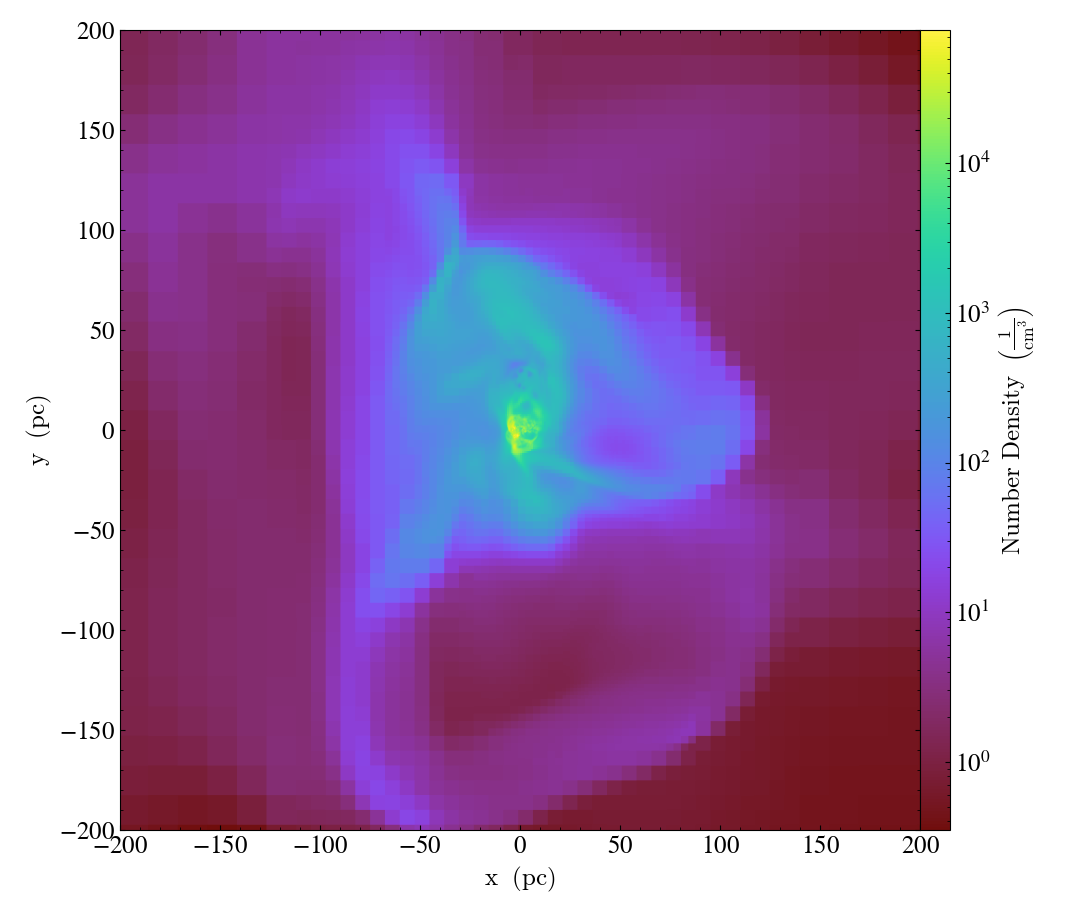

In [16]:
# Create density slice at z-plane
yt.SlicePlot(
    ds,  # Our loaded dataset
    "z",  # Slice normal direction
    ("gas", "number_density"),  # Field to visualize
    width = (plt_wdth, "pc"),  # Consistent plot size
    center = ctr_at_code  # Our calculated center
)

## Example: Gas Density Projection Plot

Creates a 2D column density map along z-axis:
- Integrates density values along line of sight
- Better for global structure analysis
- Uses same spatial parameters for direct comparison

yt : [INFO     ] 2025-04-03 22:07:50,727 Projection completed
yt : [INFO     ] 2025-04-03 22:07:50,731 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 22:07:50,732 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 22:07:50,735 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 22:07:50,736 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 22:07:50,736 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800



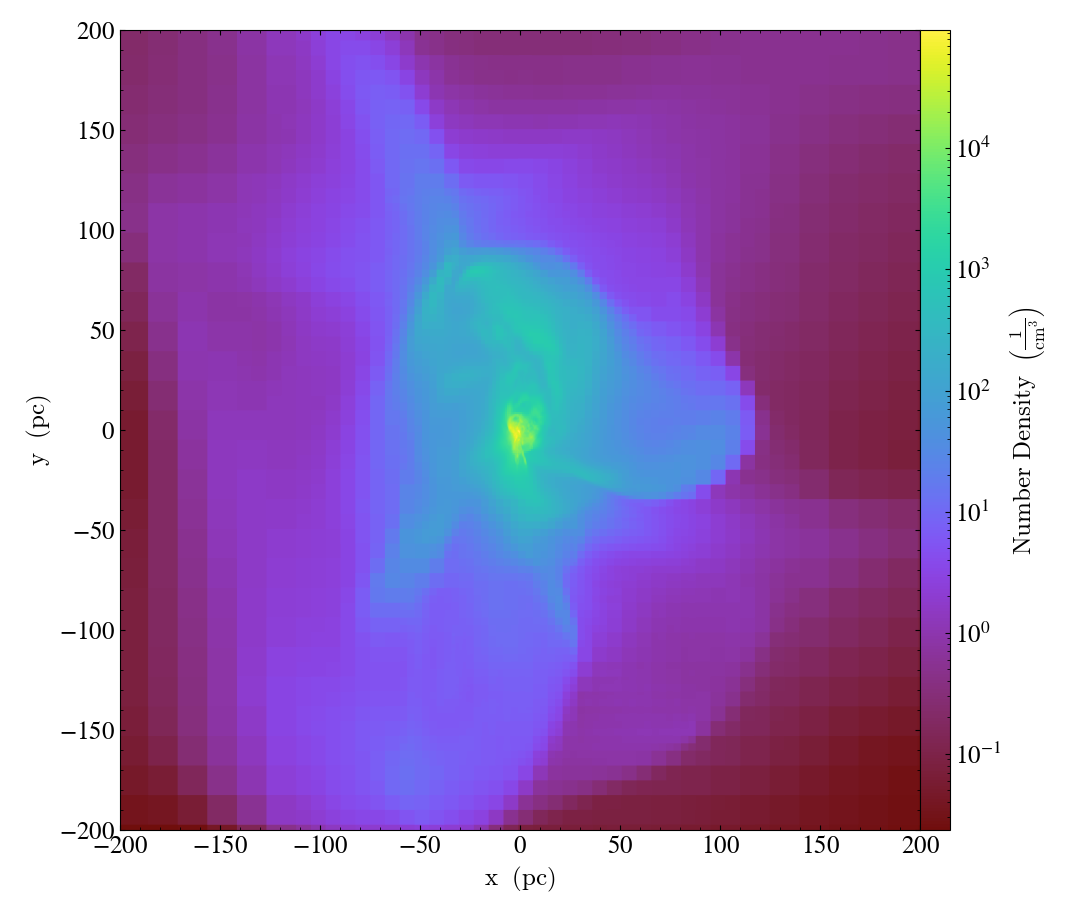

In [18]:
# Create z-projection of gas number density
yt.ProjectionPlot(
    ds,  # Loaded simulation dataset
    "z",  # Projection axis (z-direction)
    ("gas", "number_density"),  # Field to visualize
    width = (plt_wdth, "pc"),  # Plot width with physical units
    weight_field = ("gas", "number_density"),  # Density-weighted projection
    center = ctr_at_code  # Center coordinates from earlier calculation
)

## Gas Density Projection (Matplotlib)

This cell extracts and plots **just the gas density projection** using matplotlib.  

**Why?**  
yt doesn't support native scatter plots on projections.

yt : [INFO     ] 2025-04-03 22:07:54,568 Projection completed
yt : [INFO     ] 2025-04-03 22:07:54,569 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 22:07:54,569 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 22:07:54,571 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 22:07:54,571 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 22:07:54,571 Making a fixed resolution buffer of (('gas', 'number_density')) 800 by 800


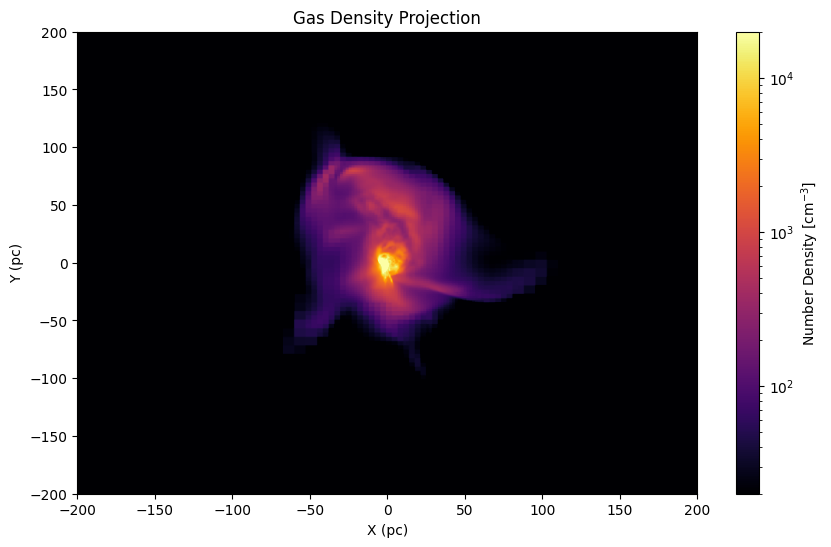

In [20]:
# Generate the density projection using yt
p = yt.ProjectionPlot(
    ds,  # Loaded dataset
    "z",  # Projection axis (z-direction)
    ("gas", "number_density"),  # Field to visualize
    width = (plt_wdth, "pc"),  # Plot width with units
    weight_field = ("gas", "number_density"),  # Self-weighted projection
    center = ctr_at_code  # Center coordinates from previous calculation
)

# Extract the pixel data for matplotlib plotting
p_frb = p.frb  # Fixed resolution buffer (2D image array)
p_img = np.array(p_frb["gas", "number_density"])  # Convert to numpy array

# Star particle data setup
star_bins = 2000  # Number of bins for particle analysis
star_mass = np.ones_like(x_pos) * 10  # Placeholder masses (10 units each)
pop2_xyz = np.array(ds.arr(np.vstack([x_pos, y_pos, z_pos]), "code_length").to("pc")).T  # Convert positions to pc

# Configure plot appearance
extent_dens = [-plt_wdth/2, plt_wdth/2, -plt_wdth/2, plt_wdth/2]  # Plot boundaries [pc]
gas_range = (20, 2e4)  # Density range for colormap [cm⁻³]
norm_gas = LogNorm(vmin = gas_range[0], vmax = gas_range[1])  # Logarithmic scaling

# Create the figure
plt.figure(figsize = (10, 6))
plt.imshow(
    p_img, 
    norm = norm_gas, 
    extent = extent_dens, 
    origin = "lower", 
    aspect = "auto", 
    cmap = "inferno"
)
plt.colorbar(label = r"Number Density [cm$^{-3}$]")

# Optional: Uncomment to overlay star particles
# plt.scatter(pop2_xyz[:, 0], pop2_xyz[:, 1], s=5, marker='.', color='red')

# Finalize plot
plt.xlabel("X (pc)")
plt.ylabel("Y (pc)")
plt.title("Gas Density Projection")
plt.xlim(-plt_wdth/2, plt_wdth/2)
plt.ylim(-plt_wdth/2, plt_wdth/2)
plt.show()

## Stellar Mass Density Plot (Matplotlib)

This cell visualizes the 2D stellar mass distribution:
- Creates a mass-weighted histogram of star particles
- Uses logarithmic scaling to highlight density variations

**Coordinate Matching**:  
Uses same spatial bounds (`plt_wdth`) as gas plot for direct comparison

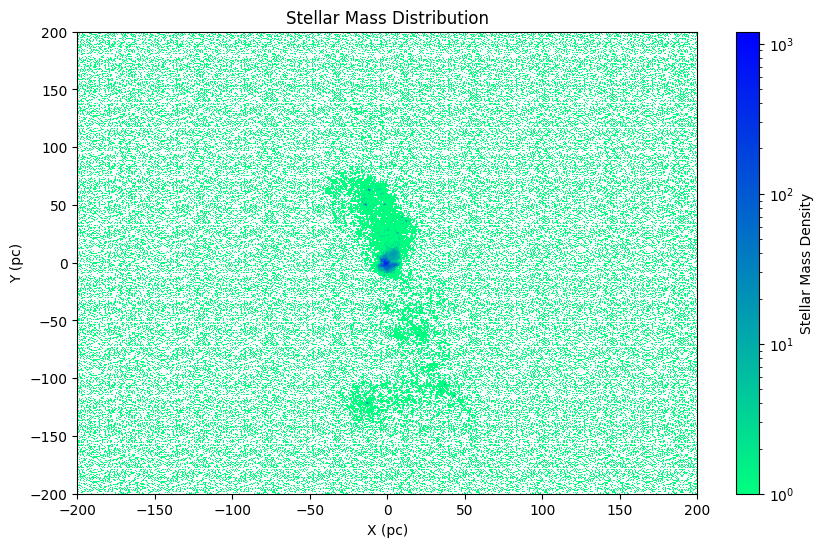

In [22]:
# Calculate 2D stellar mass density histogram
stellar_mass_dens, _, _ = np.histogram2d(
    pop2_xyz[:, 0],  # X positions [pc]
    pop2_xyz[:, 1],  # Y positions [pc]
    bins = star_bins,  # Resolution (2000 bins)
    weights = star_mass,  # Mass-weight each particle
    range = [  # Match gas plot extent
        [-plt_wdth/2, plt_wdth/2], 
        [-plt_wdth/2, plt_wdth/2]
    ],
)
stellar_mass_dens = stellar_mass_dens.T  # Transpose for imshow orientation

# Filter sparse bins (background cleanup)
stellar_mass_dens = np.where(stellar_mass_dens <= 1, 0, stellar_mass_dens)

# Configure plot
stellar_range = (1, 1200)  # Mass density range
norm_star = LogNorm(vmin = stellar_range[0], vmax = stellar_range[1])

# Generate plot
plt.figure(figsize = (10, 6))
plt.imshow(
    stellar_mass_dens,
    norm = norm_star,
    extent = extent_dens,  # Reuse gas plot bounds
    origin = 'lower',
    aspect = 'auto',
    cmap = 'winter_r'  # Blue-green colormap
)
plt.colorbar(label = "Stellar Mass Density")
plt.xlabel("X (pc)")
plt.ylabel("Y (pc)")
plt.title("Stellar Mass Distribution")
plt.show()

## Combined Gas & Stellar Density Plot

**Layered Visualization Technique**:
- **Base Layer**: Gas density (`inferno` colormap)  
- **Top Layer**: Stellar mass density (`winter_r` colormap)

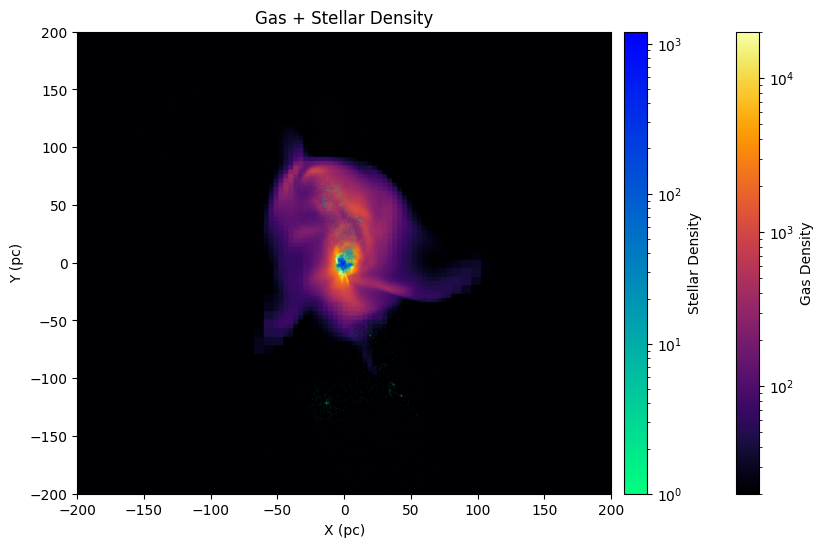

In [24]:
# Initialize figure
fig, ax = plt.subplots(figsize = (10, 6))

img1 = ax.imshow(
    p_img,  # Precomputed gas density array
    norm = norm_gas,  # Log scaling (20-2e4 cm⁻³)
    extent = extent_dens,
    origin = 'lower',
    aspect = 'auto',
    cmap = 'inferno',  # Hot colormap for gas
    alpha = 1  # Fully opaque
)
cbar1 = fig.colorbar(img1, ax = ax, orientation = 'vertical', pad = 0.02)
cbar1.set_label(r"Gas Density")

# Create transparency mask (1 where mass >1 M⊙/bin)
alpha_star = np.where(stellar_mass_dens <= 1, 0.0, 1)  

img2 = ax.imshow(
    stellar_mass_dens,
    norm = norm_star,  # Log scaling
    extent = extent_dens,
    origin = 'lower',
    aspect = 'auto',
    cmap = 'winter_r',  # Cold colormap for stars
    alpha = alpha_star  # Mask low-density bins
)
cbar2 = fig.colorbar(img2, ax = ax, orientation = 'vertical', pad = 0.02)
cbar2.set_label("Stellar Density")

ax.set(
    xlabel = "X (pc)", 
    ylabel = "Y (pc)",
    title = "Gas + Stellar Density",
    xlim = (-plt_wdth/2, plt_wdth/2),  # Enforce square aspect
    ylim = (-plt_wdth/2, plt_wdth/2)
)
plt.show()

## `Continuum` Class (PyNeb-based Spectrum Generator)

**Purpose**:  
Compute emission continua (free-free, bound-free, two-photon) for nebular spectra.

**Key Method**:  
```python
get_continuum(tem, den, wl, He1_H=0, He2_H=0, ...)
```
- `tem`: Temperature [K] (scalar or array)  
- `den`: Density [cm⁻³]  
- `wl`: Wavelengths [Å] (array)  
- Returns: Continuum flux [erg/s/cm³/Å] or normalized units

**Example**:
```python
C = Continuum()
wl = np.arange(3500, 7000)
flux = C.get_continuum(tem = 1e4, den = 1e2, wl = wl)
plt.plot(wl, flux)
```

In [26]:
class Continuum(object):
    
    def __init__(self):
        """Part of the PyNeb library.
        
        Mainly based on pySSN library        
        Adapted by V. Gomez-Llanos and C. Morisset, 2018
        """
        self.BE = None
        self.__HI_case = None
        self._set_HI_case('B')
        self.log_ = log_

        
    def _set_HI_case(self, case='B'):
        """Define the case (A or B) to be used for HI normalization line.
        
        Not sure that the Free-bound coefficients from Ercolano & Storey 2006 take case A option into account.
        
        Parameters:
            case (string): 'A' or 'B'
        """            
        if case != self.__HI_case:
            if case == 'A':
                pn.atomicData.setDataFile('h_i_rec_SH95-caseA.hdf5')
                self.HI = None
            elif case == 'B':
                pn.atomicData.setDataFile('h_i_rec_SH95.hdf5')
                self.HI = None
            else:
                raise ValueError('Unkown case {}. Should be A or B'.format(case))
            self.__HI_case = case
        
    def make_cont_Ercolano(self, tem, case, wl):
        """Adapted from http://adsabs.harvard.edu/abs/2006MNRAS.372.1875E
        
        Parameters:
            tem : electron temperature [K]. Can not be an array. 
                  In case of tem array, use get_continuum
            case: one of "H", "He1", "He2"
            wl: wavelength [Angstrom]. May be a float or a numpy array
        
        Returns:
            The continuum [erg/s.cm3/A]
        """
        try:
            _ = (e for e in wl)
        except TypeError:
            wl = np.array([wl])

        n_wl = len(wl)
        hnu =  CST.CLIGHT * 1e8 / wl * CST.HPLANCK  #!phy.c_ang_sec/wl*!phy.h
        if case == 'H':
            tab_T = 10**np.array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2,
                                  3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5,
                                  4.6, 4.7, 4.8, 4.9, 5. ])
            D = np.loadtxt(ROOT_DIR + '/' + 'atomic_data/coeff_ercolano_H.txt')
        elif case == 'He1':
            tab_T = 10**np.array([2.  , 2.04, 2.08, 2.12, 2.16, 2.2 , 2.24, 2.28, 2.32, 2.36, 2.4 ,
                                  2.44, 2.48, 2.52, 2.56, 2.6 , 2.64, 2.68, 2.72, 2.76, 2.8 , 2.84,
                                  2.88, 2.92, 2.96, 3.  , 3.04, 3.08, 3.12, 3.16, 3.2 , 3.24, 3.28,
                                  3.32, 3.36, 3.4 , 3.44, 3.48, 3.52, 3.56, 3.6 , 3.64, 3.68, 3.72,
                                  3.76, 3.8 , 3.84, 3.88, 3.92, 3.96, 4.  , 4.04, 4.08, 4.12, 4.16,
                                  4.2 , 4.24, 4.28, 4.32, 4.36, 4.4 , 4.44, 4.48, 4.52, 4.56, 4.6 ,
                                  4.64, 4.68, 4.72, 4.76, 4.8 , 4.84, 4.88, 4.92, 4.96, 5.  ])
            D = np.loadtxt(ROOT_DIR + '/' + 'atomic_data/coeff_ercolano_He1.txt')
        elif case == 'He2':
            tab_T = 10**np.array([2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2,
                                  3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5,
                                  4.6, 4.7, 4.8, 4.9, 5. ])
            D = np.loadtxt(ROOT_DIR + '/' + 'atomic_data/coeff_ercolano_He2.txt')
        else:
            self.log_.warn('Invalid case {0}'.format(case), calling='Continuum.make_cont_Ercolano')
            return np.nan
        if (tem < np.min(tab_T)).any() or (tem > np.max(tab_T)).any():
            self.log_.warn('Invalid temperature {0}'.format(tem), calling='Continuum.make_cont_Ercolano')            
            return np.nan
        
        BE_E_Ry = D[:,1]
        BE_E_erg = BE_E_Ry * CST.RYD_erg
        BE_E_Thr = BE_E_erg[D[:,0] == 1]
        Delta_E = np.zeros(n_wl)
        for i in np.arange(n_wl):
            DE = hnu[i] - BE_E_Thr
            Delta_E[i] = np.min(DE[DE > 0])
            
        n_T_sup = np.min(np.where(tab_T >= tem)[0])
        n_T_inf = n_T_sup - 1
        T_sup = tab_T[n_T_sup]
        T_inf = tab_T[n_T_inf]
        
        BE_coeff_sup = D[:, n_T_sup+2]
        BE_coeff_inf = D[:, n_T_inf+2]
        
        coeff_sup = interp1d(BE_E_erg, BE_coeff_sup)(hnu)
        coeff_inf = interp1d(BE_E_erg, BE_coeff_inf)(hnu)

        C_interp= (np.log10(tem) - np.log10(T_inf)) / (np.log10(T_sup) - np.log10(T_inf))
        
        coeff = coeff_sup * C_interp + coeff_inf*(1. - C_interp)
        
        cont = coeff * 1e-34 * tem**(-1.5) * np.exp(-Delta_E / tem / CST.BOLTZMANN) / wl**2. * CST.CLIGHT * 1e8 # erg/s.cm3/A
        return cont.squeeze()

    def two_photon(self, tem, den, wl):
        """
        Parameters:
            tem: temperature [K]. May be a float or a numpy array
            den: density [cm-3]
            wl: wavelength [Angstrom]. May be a float or a numpy array
            
        Returns:
            2 photons continuum [erg/s.cm3/A]
        """
        #ToDo : See Schirmer, M. 2016, PASP, 128, 114001 
        try:
            _ = (e for e in wl)
        except TypeError:
            wl = np.array([wl])
        y = 1215.7 / wl
        A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)
        mask = y > 1.0 # Thanks to Daniel Schaerer for pointing out this potential issue
        A[mask] = 0.
        alfa_eff = 0.838e-13 * (tem / 1e4)**(-0.728) # fit DP de Osterbrock
        q = 5.31e-4 * (tem / 1e4)**(-0.17) # fit DP de Osterbrock
        n_crit = 8.226 / q
        twophot_cont = CST.HPLANCK * CST.CLIGHT * 1e8 / wl**3. * 1215.7 * A / 8.226 * alfa_eff / \
                       (1. + den/n_crit)                
        #twophot_cont[~np.isfinite(twophot_cont)] = 0.
        return twophot_cont
            
    def gff(self, Z, tem, wl):
        """Adaptated from http://adsabs.harvard.edu/abs/1991CoPhC..66..129S
        
        Parameters:
            Z: atomic number
            tem: temperature [K]
            wk: wavelength [Angstrom]
        """
        D= np.array([8.986940175e+00, -4.009515855e+00,  8.808871266e-01,
            2.640245111e-02, -4.580645915e-02, -3.568055702e-03,   
            2.827798067e-03,  3.365860195e-04, -8.006936989e-01,
            9.466021705e-01,  9.043402532e-02, -9.608451450e-02,
            -1.885629865e-02,  1.050313890e-02,  2.800889961e-03, 
            -1.078209202e-03, -3.781305103e-01,  1.102726332e-01, 
            -1.543619180e-02,  8.310561114e-03,  2.179620525e-02, 
            4.259726289e-03, -4.181588794e-03, -1.770208330e-03,   
            1.877213132e-02, -1.004885705e-01, -5.483366378e-02,   
            -4.520154409e-03,  8.366530426e-03,  3.700273930e-03, 
            6.889320423e-04,  9.460313195e-05,  7.300158392e-02,   
            3.576785497e-03, -4.545307025e-03, -1.017965604e-02,   
            -9.530211924e-03, -3.450186162e-03,  1.040482914e-03, 
            1.407073544e-03, -1.744671550e-03,  2.864013856e-02,   
            1.903394837e-02,  7.091074494e-03, -9.668371391e-04,   
            -2.999107465e-03, -1.820642230e-03, -3.874082085e-04, 
            -1.707268366e-02, -4.694254776e-03,  1.311691517e-03, 
            5.316703136e-03,  5.178193095e-03,  2.451228935e-03,   
            -2.277321615e-05, -8.182359057e-04,  2.567331664e-04, 
            -9.155339970e-03, -6.997479192e-03, -3.571518641e-03, 
            -2.096101038e-04,  1.553822487e-03,  1.509584686e-03, 
            6.212627837e-04,  4.098322531e-03,  1.635218463e-03,   
            -5.918883504e-04, -2.333091048e-03, -2.484138313e-03, 
            -1.359996060e-03, -5.371426147e-05,  5.553549563e-04, 
            3.837562402e-05,  2.938325230e-03,  2.393747064e-03,   
            1.328839809e-03,  9.135013312e-05, -7.137252303e-04,   
            -7.656848158e-04, -3.504683798e-04, -8.491991820e-04, 
            -3.615327726e-04,  3.148015257e-04,  8.909207650e-04, 
            9.869737522e-04,  6.134671184e-04,  1.068883394e-04,   
            -2.046080100e-04 ])
    
        try:
            _ = (e for e in wl)
        except TypeError:
            wl = np.array([wl])
    
    
        XLF = np.log10(CST.CLIGHT * 1e8 / wl)
        N_wl = len(wl)
        G = np.zeros(N_wl)
        D = D.reshape(11, 8)
        B = np.zeros(11)
        C = np.zeros(8)
    
        XLRKT = 5.1983649 - np.log10(tem)
        TXG = 0.66666667 * (2.0 * np.log10(Z) + XLRKT)
    
        for j in np.arange(7):
            B[10] = D[10, j]
            B[9] = TXG * B[10] + D[9, j]
            for IR in np.arange(8)[::-1]:
                B[IR] = TXG * B[IR+1] - B[IR+2] + D[IR, j]
            C[j] = 0.25 * (B[0] - B[2])               
    
    
        CON=0.72727273 * XLRKT - 10.376127  
    
        for i in np.arange(N_wl):
            TXU = 0.72727273 * XLF[i] + CON 
            B[7] = C[7]
            B[6] = TXU * B[7] + C[6] 
            for IR in np.arange(5)[::-1]: 
                B[IR] = TXU * B[IR+1] - B[IR+2] + C[IR]
            G[i] = B[0] - B[2]
    
        return G.squeeze()

    def FreeFree(self, tem, wl, He1_H=0., He2_H=0., tem_HeI=None, tem_HeII=None):
        """
        Parameters:
            tem:
            wl:
            He1_H (float) default: 0.
            He2_H (float) default: 0.
            tem_HeI (float) default: None.
            tem_HeII (float) default: None.
        """
        if tem_HeI is None:
            tem_HeI = tem
        if tem_HeII is None:
            tem_HeII = tem
            
        gff_HI = self.gff(1., tem, wl)
        gff_HeI = self.gff(1., tem_HeI, wl)
        gff_HeII = self.gff(4., tem_HeII, wl)

        FF_cont = (6.8391014e-38 * CST.CLIGHT * 1e8 / wl**2. * (
                        1.0**2. / np.sqrt(tem) * np.exp(-CST.HPLANCK*CST.CLIGHT*1e8/wl/CST.BOLTZMANN/tem) * gff_HI + 
                        He1_H * 1.0**2./ np.sqrt(tem_HeI) * np.exp(-CST.HPLANCK*CST.CLIGHT*1e8/wl/CST.BOLTZMANN/tem_HeI) * gff_HeI  + 
                        He2_H* 2.0**2. / np.sqrt(tem_HeII) * np.exp(-CST.HPLANCK*CST.CLIGHT*1e8/wl/CST.BOLTZMANN/tem_HeII) * gff_HeII))
        return FF_cont
    
    def _get_continuum1(self, tem, den, He1_H=0., He2_H=0., wl=None, 
                      cont_HI=True, cont_HeI=True, cont_HeII=True, 
                      cont_2p=True, cont_ff=True):
        """
        Type of continuum to take into acount defined a boolean, defaults are True
        
        Parameters:
            tem: temperature [K]. May be a float or an iterable
            den: density [cm-3]. May be a float or an iterable. If iterable, must have same size than tem
            He1_H and He2_H: He+/H+ and He++/H+ abundances. Default = 0.0
            wl: wavelengths: May be an array
            cont_HI (bool) default: True
            cont_HeI (bool) default: True
            cont_HeII (bool) default:True using B. Ercolano 2006 data
            cont_2p (bool) default: True 2 photons, using D. Pequignot fit to Osterbrock
            cont_ff (bool) default: 
            
        Returns:
            The resulting continuum [erg/s.cm3/A]
        """

        cont = 0.
        if cont_HI:
            cont += self.make_cont_Ercolano(tem = tem, case = 'H', wl = wl)
        if cont_HeI and He1_H > 0.:
            cont += He1_H * self.make_cont_Ercolano(tem = tem, case = 'He1', wl = wl)
        if cont_HeII and He2_H > 0:
            cont += He2_H * self.make_cont_Ercolano(tem = tem, case = 'He2', wl = wl)
        if cont_2p:
            cont += self.two_photon(tem = tem, den = den, wl = wl)
        if cont_ff:
            cont += self.FreeFree(tem = tem, wl = wl, He1_H=He1_H, He2_H=He2_H)
        
        return cont

    def get_continuum(self, tem, den, He1_H=0., He2_H=0., wl=np.array([3500, 3600, 3700, 3800, 3900]), 
                      cont_HI=True, cont_HeI=True, cont_HeII=True, 
                      cont_2p=True, cont_ff=True, HI_label='11_2'):
        """
        
        Type of continuum to take into acount defined a boolean, defaults are True
        
        Parameters:
            tem: temperature [K]. May be a float or an iterable.
            den: density [cm-3]. May be a float or an iterable. If iterable, must have same size than tem.
            He1_H (float):  He+/H+ abundance. Default = 0.0
            He2_H (float): He++/H+ abundances.  Default = 0.0
            wl (np.array): Wavelengths Default = np.array([3500, 3600, 3700, 3800, 3900])
            cont_HI (bool): using B. Ercolano 2006 data. Default: True
            cont_HeI (bool): using B. Ercolano 2006 data. Default: True
            cont_HeII (bool): using B. Ercolano 2006 data. Default: True
            cont_2p (bool): 2 photons, using D. Pequignot fit to Osterbrock. Default: True
            cont_ff (bool): from Storey & Hummer 1991. Default: True
            
            HI_label (str): HI label to normalize the continuum. If None, no normalization is done. Default: '11_2'
            
        Returns:
            The resulting continuum. Unit [A-1] if normalized, [erg/s.cm3/A] otherwise
        
        Exemple of use:
            C = pn.Continuum()
            wl = np.arange(3500, 4000, 1)
            cont = C.get_continuum(tem=1e4, den=1e2, He1_H=0.08, He2_H=0.02, wl=wl)
            plt.plot(wl, cont)
        """
        try:
            _ = (e for e in tem)
            T_iterable = True
            try:
                _ = (e for e in den)
            except:
                den = np.ones_like(tem) * den
            try:
                _ = (e for e in He1_H)
            except:
                He1_H = np.ones_like(tem) * He1_H
            try:
                _ = (e for e in He2_H)
            except:
                He2_H = np.ones_like(tem) * He2_H
            
        except TypeError:
            T_iterable = False
        if HI_label is None:
            norm = 1.0
        else:
            if self.HI is None:
                self.HI = pn.RecAtom('H',1)
            norm = self.HI.getEmissivity(tem, den, label = HI_label, product=False)
            
        if T_iterable:
            cont = np.array(list(map(lambda t, d, He1_H_1,He2_H_1 : self._get_continuum1(t, d, 
                                                                                  He1_H=He1_H_1, 
                                                                                  He2_H=He2_H_1, 
                                                                                  wl=wl, 
                                                                                  cont_HI=cont_HI, 
                                                                                  cont_HeI=cont_HeI, 
                                                                                  cont_HeII=cont_HeII, 
                                                                                  cont_2p=cont_2p, 
                                                                                  cont_ff=cont_ff), 
                                     tem, den, He1_H, He2_H))).T
            return cont.squeeze()/norm
        else:
            cont = self._get_continuum1(tem, den, He1_H=He1_H, He2_H=He2_H, wl=wl, 
                                        cont_HI=cont_HI, cont_HeI=cont_HeI, cont_HeII=cont_HeII, 
                                        cont_2p=cont_2p, cont_ff=cont_ff)
            return cont/norm
    
    def BJ_HI(self, tem, den, He1_H, He2_H, wl_bbj = 3643, wl_abj = 3861, HI_label='11_2'):
        """
        Parameters:
            tem: temperature [K]. May be a float or an iterable
            den: density [cm-3]. May be a float or an iterable. If iterable, must have same size than tem
            He1_H: He+/H+ abundances.
            He2_H: He++/H+ abundances.
        
            wl_bbj (int): wavelengths below the jump resp. Default: 3643
            wl_abj (int): wavelengths above the jump resp. Defaults: 3861
            HI_label (str): reference HI line to normalize the jump. Default is 11_2
        
        Returns:
            The Balmer Jump (may be any other jump if wl are changed) normalized to the HI line
        """
        
        fl_bbj, fl_abj = self.get_continuum(tem = tem, den = den, He1_H = He1_H, 
                                            He2_H = He2_H, wl = np.array([wl_bbj, wl_abj]),
                                            HI_label=HI_label)
        
        BJ_HI = fl_bbj - fl_abj
        return BJ_HI
    
    def T_BJ(self, BJ_HI, den, He1_H, He2_H, wl_bbj = 3643, wl_abj = 3861, HI_label='11_2',
             T_min=5e2, T_max=3e4):
        """
        Parameters:
            BJ_HI: Balmer Jump (may be any other jump if wl are changed) normalized to the HI line
            den: density [cm-3]. May be a float or an iterable. If iterable, must have same size than tem
            He1_H: He+/H+ abundances.
            He2_H: He++/H+ abundances.
            wl_bbj (int): wavelengths below the jump resp. Default: 3643
            wl_abj (int): wavelengths above the jump resp. Defaults: 3861
            HI_label: reference HI line to normalize the jump. Default: 11_2
        
            T_min: minimum temperature [K] for the root finding exploration. Default: 5e2
            T_max: maximum temperature [K] for the root finding exploration. Default: 3e4
        
        Returns:
            Temperature [K] corresponding to the jump
        """
        try:
            _ = (e for e in BJ_HI)
            BJ_iterable = True
        except TypeError:
            BJ_iterable = False
            
        def f2minimize(tem, BJ_HI):
            f = self.BJ_HI(tem, den=den, He1_H=He1_H, He2_H=He2_H, wl_bbj = wl_bbj, wl_abj=wl_abj, HI_label=HI_label) - BJ_HI
            return f

        def f2minimize_i(tem, i):
            f = self.BJ_HI(tem, den=den.ravel()[i], He1_H=He1_H.ravel()[i], He2_H=He2_H.ravel()[i], 
                           wl_bbj = wl_bbj, wl_abj=wl_abj, HI_label=HI_label) - BJ_HI.ravel()[i]
            return f
            
        if BJ_iterable:
            T_BJ = np.array(list(map(lambda i: optimize.brentq(f2minimize_i, T_min, T_max, args=i), np.arange(len(BJ_HI.ravel()))))).T
            return T_BJ.squeeze()
        else:
            T_BJ = optimize.brentq(f2minimize, T_min, T_max, args=BJ_HI)
            return T_BJ

    
    def T_BJ_Liu(self, BJ_H11, He1_H, He2_H):
        """
        From Liu, X.-W., Luo, S.-G., Barlow, M. J., Danziger, I. J., & Storey, P. J.
        2001, MNRAS, 327, 141-168
        
        Parameters:
            BJ_H11: Balmer Jump normalized to the H11 line
            He1_H: He+/H+ abundances.
            He2_H: He++/H+ abundances.
        """
        T = 368 * (1 + 0.259 * He1_H + 3.409 * He2_H) * (BJ_H11)**(-3./2)
        return T

## Nebular Continuum Components at 5,000 K

**Cosmological Redshift Scaling**:  
The factor `(1+z)` accounts for:  
- **Wavelength stretching**: Observed wavelength $λ_{\text{obs}} = λ_{\text{emit}}(1+z)$  

**Key Parameters**:  
- **Temperature**: 5,000 K (H II region / planetary nebula regime)  
- **Density**: $10^4$ cm$^{-3}$ (typical for dense nebulae)  
- **Wavelength Range**: 83–10,000 Å (rest-frame) → 913–110,000 Å (observed at z=10)  
- **Helium**: Disabled (`He1_H=0, He2_H=0`) for pure hydrogen case  

**Plot Units**:  
- **X-axis**: Observer-frame wavelength [Å] (log-scaled)  
- **Y-axis**: $4πλj_λ/(n_en_p)$ [erg s$^{-1}$ cm$^3$]   

/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


Text(0.5, 1.0, '$Temperature = 5\\times10^3$ K, $Density = 10^4$ cm$^{-3}$')

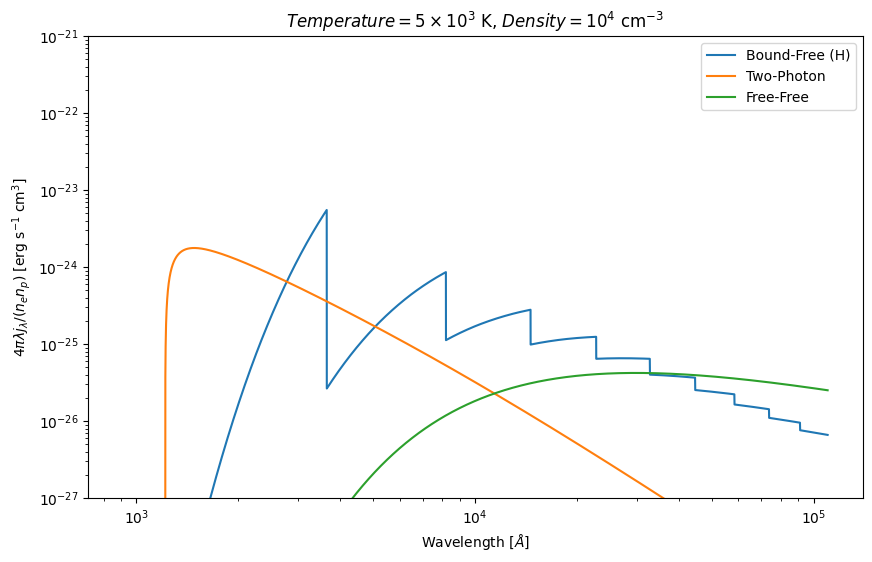

In [28]:
# Initialize continuum calculator
C = pn.Continuum()
z = 10  # Redshift (extends wavelength range)
dense = 1e4  # density [cm⁻³]

# Create log-spaced wavelength array (rest-frame)
wl = np.logspace(np.log10(83 * (1 + z)), np.log10(10000 * (1 + z)), 8000)

# Compute continuum components
contH = C.get_continuum(tem = 5e3, den = dense, wl = wl, HI_label = None, 
                        cont_HI = True, cont_HeI = False, cont_HeII = False,  # Bound-free only
                        cont_2p = False, cont_ff = False)

cont2p = C.get_continuum(tem = 5e3, den = dense, wl = wl, HI_label = None,
                         cont_HI = False, cont_HeI = False, cont_HeII = False,  # Two-photon only
                         cont_2p = True, cont_ff = False)

contff = C.get_continuum(tem = 5e3, den = dense, wl = wl, HI_label = None,
                         cont_HI = False, cont_HeI = False, cont_HeII = False,  # Free-free only
                         cont_2p = False, cont_ff = True)

# Plot (multiply by λ to convert j_λ → λj_λ)
plt.figure(figsize = (10, 6))
plt.plot(wl, contH * wl, label = 'Bound-Free (H)')
plt.plot(wl, cont2p * wl, label = 'Two-Photon')
plt.plot(wl, contff * wl, label = 'Free-Free')

# Formatting
plt.legend()
plt.ylim(1e-27, 1e-21)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"Wavelength [$\AA$]")
plt.ylabel(r"$4\pi\lambda j_\lambda/(n_e n_p)$ [erg s$^{-1}$ cm$^3$]")
plt.title(r"$Temperature = 5\times10^3$ K, $Density = 10^4$ cm$^{-3}$")

## Temperature-Dependent Nebular Continuum (Fixed Density: $10^4$ cm$^{-3}$)

**Plot Structure**:  
- Left: 5,000 K
- Right: 10,000 K
- Shared y-axis for direct comparison  

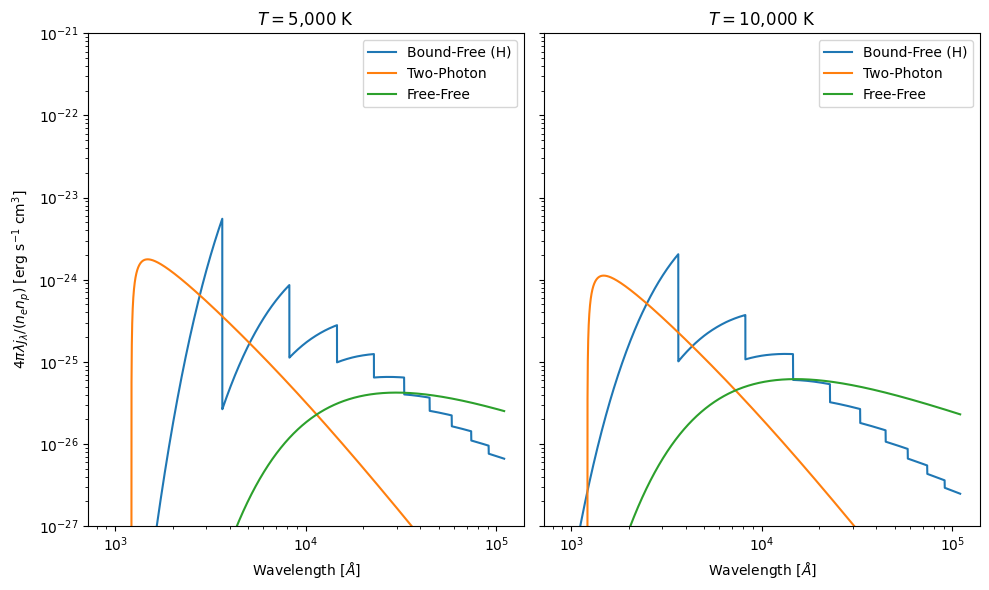

In [30]:
C = pn.Continuum()
z = 10
dense = 1e4
wl = np.logspace(np.log10(83 * (1 + z)), np.log10(10000 * (1 + z)), 8000)

# Calculate all components
components = {
    '5k': {
        'contH': C.get_continuum(tem = 5e3, den = dense, wl = wl, HI_label = None, 
                                cont_HI = True, cont_HeI = False, cont_HeII = False,
                                cont_2p = False, cont_ff = False),
        'cont2p': C.get_continuum(tem = 5e3, den = dense, wl = wl, HI_label = None,
                                 cont_HI = False, cont_HeI = False, cont_HeII = False,
                                 cont_2p = True, cont_ff = False),
        'contff': C.get_continuum(tem = 5e3, den = dense, wl = wl, HI_label = None,
                                 cont_HI = False, cont_HeI = False, cont_HeII = False,
                                 cont_2p = False, cont_ff = True)
    },
    '10k': {
        'contH': C.get_continuum(tem = 10e3, den = dense, wl = wl, HI_label = None, 
                                cont_HI = True, cont_HeI = False, cont_HeII = False,
                                cont_2p = False, cont_ff = False),
        'cont2p': C.get_continuum(tem = 10e3, den = dense, wl = wl, HI_label = None,
                                 cont_HI = False, cont_HeI = False, cont_HeII = False,
                                 cont_2p = True, cont_ff = False),
        'contff': C.get_continuum(tem = 10e3, den = dense, wl = wl, HI_label = None,
                                 cont_HI = False, cont_HeI = False, cont_HeII = False,
                                 cont_2p = False, cont_ff = True)
    }
}

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6), sharey = True)

# Plot 5,000 K components
ax1.plot(wl, components['5k']['contH'] * wl, label = 'Bound-Free (H)')
ax1.plot(wl, components['5k']['cont2p'] * wl, label = 'Two-Photon')
ax1.plot(wl, components['5k']['contff'] * wl, label = 'Free-Free')
ax1.set_title(r"$T = 5,\!000$ K")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r"Wavelength [$\AA$]")
ax1.set_ylabel(r"$4\pi\lambda j_\lambda/(n_e n_p)$ [erg s$^{-1}$ cm$^3$]")
ax1.legend()
ax1.set_ylim(1e-27, 1e-21)

# Plot 10,000 K components
ax2.plot(wl, components['10k']['contH'] * wl, label = 'Bound-Free (H)')
ax2.plot(wl, components['10k']['cont2p'] * wl, label = 'Two-Photon')
ax2.plot(wl, components['10k']['contff'] * wl, label = 'Free-Free')
ax2.set_title(r"$T = 10,\!000$ K")
ax2.set_xscale('log')
ax2.set_xlabel(r"Wavelength [$\AA$]")
ax2.legend()

plt.tight_layout()
plt.show()

## Density-Dependent Nebular Continuum (Fixed Temperature: 5,000 K)

**Plot Structure**:  
- Left: $density = 10^4$ cm$^{-3}$ 
- Right: $density = 2 \times 10^4$ cm$^{-3}$ 
- Shared y-axis for direct comparison  

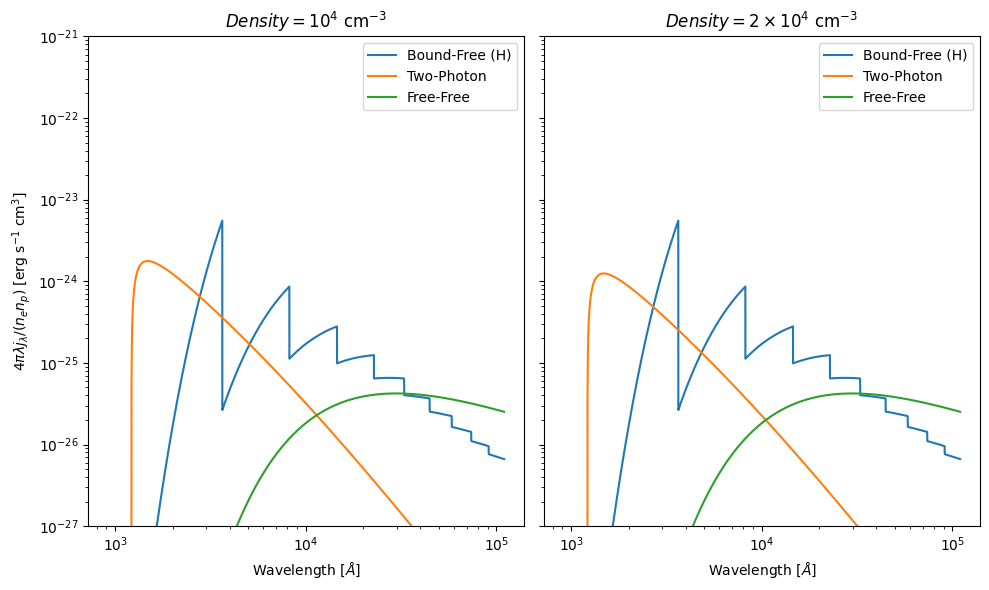

In [32]:
C = pn.Continuum()
z = 10
dense = 1e4
wl = np.logspace(np.log10(83 * (1 + z)), np.log10(10000 * (1 + z)), 8000)

# Calculate all components
components = {
    '1e4': {
        'contH': C.get_continuum(tem = 5e3, den = dense, wl = wl, HI_label = None, 
                                cont_HI = True, cont_HeI = False, cont_HeII = False,
                                cont_2p = False, cont_ff = False),
        'cont2p': C.get_continuum(tem = 5e3, den = dense, wl = wl, HI_label = None,
                                 cont_HI = False, cont_HeI = False, cont_HeII = False,
                                 cont_2p = True, cont_ff = False),
        'contff': C.get_continuum(tem = 5e3, den = dense, wl = wl, HI_label = None,
                                 cont_HI = False, cont_HeI = False, cont_HeII = False,
                                 cont_2p = False, cont_ff = True)
    },
    '2e4': {
        'contH': C.get_continuum(tem = 5e3, den = 2 * dense, wl = wl, HI_label = None, 
                                cont_HI = True, cont_HeI = False, cont_HeII = False,
                                cont_2p = False, cont_ff = False),
        'cont2p': C.get_continuum(tem = 5e3, den = 2 * dense, wl = wl, HI_label = None,
                                 cont_HI = False, cont_HeI = False, cont_HeII = False,
                                 cont_2p = True, cont_ff = False),
        'contff': C.get_continuum(tem = 5e3, den = 2 * dense, wl = wl, HI_label = None,
                                 cont_HI = False, cont_HeI = False, cont_HeII = False,
                                 cont_2p = False, cont_ff = True)
    }
}

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6), sharey = True)

# Plot density= 1e4 cm^-3
ax1.plot(wl, components['1e4']['contH'] * wl, label = 'Bound-Free (H)')
ax1.plot(wl, components['1e4']['cont2p'] * wl, label = 'Two-Photon')
ax1.plot(wl, components['1e4']['contff'] * wl, label = 'Free-Free')
ax1.set_title(r"$Density = 10^4\ \mathrm{cm}^{-3}$")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r"Wavelength [$\AA$]")
ax1.set_ylabel(r"$4\pi\lambda j_\lambda/(n_e n_p)$ [erg s$^{-1}$ cm$^3$]")
ax1.legend()
ax1.set_ylim(1e-27, 1e-21)

# Plot density = 2e4 cm^-3
ax2.plot(wl, components['2e4']['contH'] * wl, label = 'Bound-Free (H)')
ax2.plot(wl, components['2e4']['cont2p'] * wl, label = 'Two-Photon')
ax2.plot(wl, components['2e4']['contff'] * wl, label = 'Free-Free')
ax2.set_title(r"$Density = 2 \times 10^4\ \mathrm{cm}^{-3}$")
ax2.set_xscale('log')
ax2.set_xlabel(r"Wavelength [$\AA$]")
ax2.legend()

plt.tight_layout()
plt.show()

# JWST F200W Filter Analysis

**Transmission profile** of NIRCam's F200W filter (2.0 μm/20,000 Å broadband):
- Loaded from `F200W_filter.txt` (wavelength in μm → converted to Å)
- Transmission curve plotted with logarithmic wavelength scaling
- Integral calculated for flux normalization

<>:23: SyntaxWarning: invalid escape sequence '\A'
<>:23: SyntaxWarning: invalid escape sequence '\A'
/var/folders/y8/d2bctrt56rx8ckzh_kb2pxl40000gn/T/ipykernel_6158/1896713720.py:23: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel('Wavelength ($\AA$)', fontsize = 12)


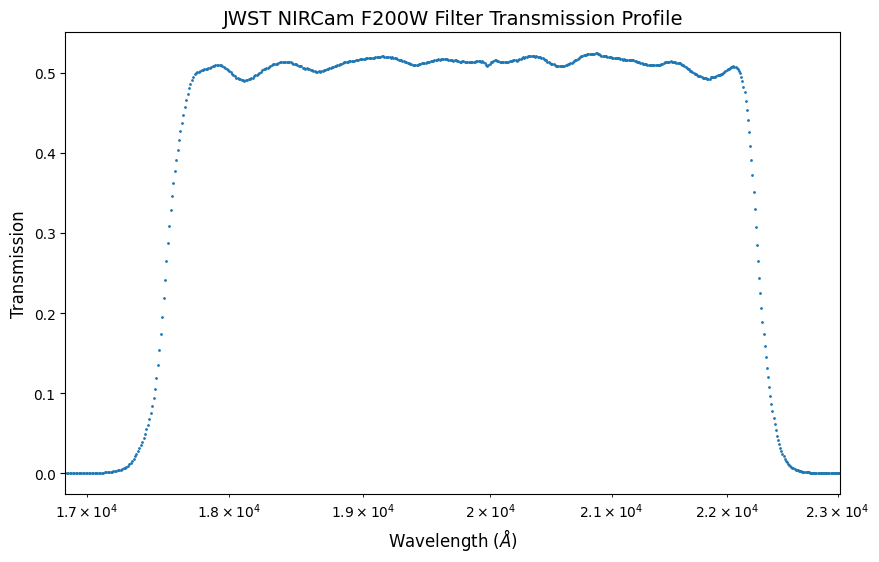

In [34]:
# Load filter data - file contains wavelength (microns) and transmission values
F200W = np.loadtxt('F200W_filter.txt', skiprows = 1)  # Skip header row

# Create DataFrame for better column handling
df_F200W = pd.DataFrame(F200W, columns = ['Wavelength [Microns]', 'Output'])

# Convert wavelength from microns to Angstroms (1 micron = 10,000 Angstroms)
wavelength_F200W = df_F200W['Wavelength [Microns]'] * 1e4  

# Get transmission values
output_F200W = df_F200W['Output']

# Calculate integral of filter response (useful for normalization)
# We multiply by wavelength because this is typically how filter curves are weighted
integral_filter_F200W = np.abs(np.trapz(output_F200W * wavelength_F200W, wavelength_F200W))

# Plot the filter transmission curve
plt.figure(figsize = (10, 6))
plt.scatter(wavelength_F200W, output_F200W, s = 1)

# Format plot
plt.xlim(np.min(wavelength_F200W), np.max(wavelength_F200W))
plt.xlabel('Wavelength ($\AA$)', fontsize = 12)
plt.ylabel('Transmission', fontsize = 12)
plt.xscale('log')  # Log scale often better for broad wavelength ranges
plt.title('JWST NIRCam F200W Filter Transmission Profile', fontsize = 14)
plt.show()

# Continuous Spectrum Analysis with JWST F200W Filter

**Plot shows** continuum emission components at Temperature = 5000 K, Density =10⁴ cm⁻³:
- Hydrogen bound-free (`contH`)
- Hydrogen 2-photon (`cont2p`) 
- Free-free (`contff`) emission

**F200W filter bandpass** marked in red, demonstrating JWST's spectral coverage

*Y-axis shows normalized emission measure (4πλjλ/nₑnₚ)*

<>:18: SyntaxWarning: invalid escape sequence '\A'
<>:18: SyntaxWarning: invalid escape sequence '\A'
/var/folders/y8/d2bctrt56rx8ckzh_kb2pxl40000gn/T/ipykernel_6158/2067523857.py:18: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel("Wavelength ($\AA$)")


Text(0.5, 1.0, 'Continuous Spectrum with F200W Filter')

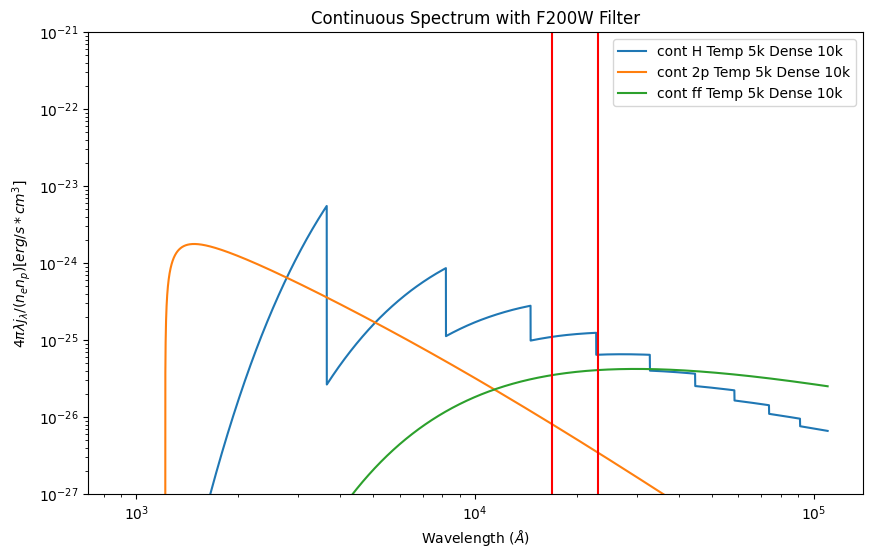

In [36]:
# Plot continuum emission components (multiplied by wavelength for λFλ representation)
plt.figure(figsize = (10, 6))
plt.plot(wl, contH * wl, label = 'cont H Temp 5k Dense 10k')  # Hydrogen bound-free
plt.plot(wl, cont2p * wl, label = 'cont 2p Temp 5k Dense 10k')  # Two-photon decay
plt.plot(wl, contff * wl, label = 'cont ff Temp 5k Dense 10k')  # Free-free (bremsstrahlung)

# Mark F200W filter boundaries
wl_F200W_min = np.min(wavelength_F200W)  # Short-wavelength cutoff (Å)
wl_F200W_max = np.max(wavelength_F200W)  # Long-wavelength cutoff (Å)
plt.axvline(x = wl_F200W_min, color = 'r')  # Vertical line at min wavelength
plt.axvline(x = wl_F200W_max, color = 'r')  # Vertical line at max wavelength

# Format plot
plt.legend()
plt.ylim(1e-27, 1e-21)  # Characteristic flux range for T=5000K
plt.xscale('log')  # Logarithmic wavelength axis
plt.yscale('log')  # Logarithmic flux axis
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel(r"$4\pi\lambda j_\lambda /(n_e n_p) [erg/s * cm^3]$")  # Normalized emission measure
plt.title('Continuous Spectrum with F200W Filter')

# Zoomed View: Continuum Emission in JWST F200W Bandpass

**Focusing on the F200W filter range** (${:.1f}-{:.1f} Å):
- Isolates emission processes within JWST's detectable window
- Reveals relative contributions of:
  - Hydrogen bound-free (`contH`)
  - Two-photon (`cont2p`) 
  - Free-free (`contff`) mechanisms

*Flux units: $4\pi\lambda j_\lambda/(n_e n_p)$ [erg/s * cm³]*

<>:16: SyntaxWarning: invalid escape sequence '\A'
<>:16: SyntaxWarning: invalid escape sequence '\A'
/var/folders/y8/d2bctrt56rx8ckzh_kb2pxl40000gn/T/ipykernel_6158/1429825037.py:16: SyntaxWarning: invalid escape sequence '\A'
  plt.xlabel("Wavelength ($\AA$)")


Text(0.5, 1.0, 'Zoomed: Continuous Spectrum in F200W Filter')

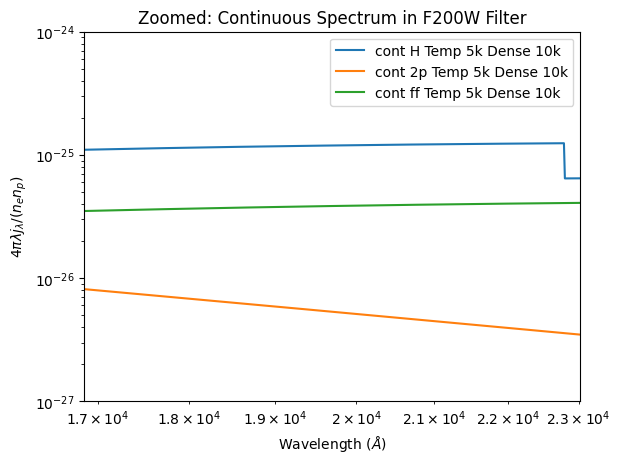

In [38]:
# Zoom into the F200W filter for detailed integration
tolerance = 1e-10  # Small buffer to ensure full wavelength coverage
mask = (wl >= wl_F200W_min - tolerance) & (wl <= wl_F200W_max + tolerance)  # Boolean filter for wavelengths

# Plot continuum components within filter range
plt.plot(wl[mask], contH[mask] * wl[mask], label = 'cont H Temp 5k Dense 10k')  # Bound-free
plt.plot(wl[mask], cont2p[mask] * wl[mask], label = 'cont 2p Temp 5k Dense 10k')  # Two-photon
plt.plot(wl[mask], contff[mask] * wl[mask], label = 'cont ff Temp 5k Dense 10k')  # Free-free

# Format plot
plt.legend()
plt.xlim(wl_F200W_min, wl_F200W_max)  # Strictly enforce filter boundaries
plt.ylim(1e-27, 1e-24)  # Adjusted y-range for zoomed view
plt.xscale('log')  # Maintain logarithmic wavelength
plt.yscale('log')  # Logarithmic flux scale
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel(r"$4\pi\lambda j_\lambda /(n_e n_p)$")  # Normalized emission measure
plt.title('Zoomed: Continuous Spectrum in F200W Filter')

# Flux Averaging Through JWST F200W Filter

**Filter-Weighted Flux Calculation**  
The average flux density $\langle f \rangle$ through the F200W filter is computed using the JWST standard formula:

$$
\langle f \rangle = \frac{
    \int_{\lambda_{\text{min}}}^{\lambda_{\text{max}}} \lambda \cdot f(\lambda) \cdot T(\lambda) \,d\lambda
}{
    \int_{\lambda_{\text{min}}}^{\lambda_{\text{max}}} \lambda \cdot T(\lambda) \,d\lambda
}
$$

where:
- $f(\lambda) = df/d\lambda [erg/s cm^3/A]$
- $T(\lambda)$ = filter transmission curve
- $\lambda$ = wavelength (Å)
We use $f(\lambda) = 4  \pi * df/d\lambda/(n_{e} n_{p})$

In [40]:
# JWST F200W Filter Flux Calculation (∝ n_p n_e)
# Interpolate continua onto filter wavelength grid
fluxH_interp = interp1d(wl[mask], contH[mask] * wl[mask], kind = 'linear', fill_value = 'extrapolate')
flux2p_interp = interp1d(wl[mask], cont2p[mask] * wl[mask], kind = 'linear', fill_value = 'extrapolate')
fluxff_interp = interp1d(wl[mask], contff[mask] * wl[mask], kind = 'linear', fill_value = 'extrapolate')

# Apply filter transmission and calculate weighted integrals
result_contH = fluxH_interp(wavelength_F200W) * output_F200W
result_cont2p = flux2p_interp(wavelength_F200W) * output_F200W
result_contff = fluxff_interp(wavelength_F200W) * output_F200W

integral_contH = np.abs(np.trapz(result_contH, wavelength_F200W))
integral_cont2p = np.abs(np.trapz(result_cont2p, wavelength_F200W))
integral_contff = np.abs(np.trapz(result_contff, wavelength_F200W))

# Compute relative flux ratios (normalized by filter integral)
flux_avg_H = integral_contH / integral_filter_F200W  # ∝ n_p n_e
flux_avg_2p = integral_cont2p / integral_filter_F200W
flux_avg_ff = integral_contff / integral_filter_F200W

# Show the result
print(f"The flux average of H is {flux_avg_H}")
print(f"The flux average of 2p is {flux_avg_2p}")
print(f"The flux average of ff is {flux_avg_ff}")

The flux average of H is 5.992343789698176e-30
The flux average of 2p is 2.659851305056601e-31
The flux average of ff is 1.9352850384249214e-30


# JWST F200W Flux Analysis Across Temperatures/Densities

Calculates filter-weighted average fluxes for:
- Hydrogen bound-free (`contH`)
- Two-photon (`cont2p`)  
- Free-free (`contff`) emission

**Parameters**:
- Temperature: 1,000K–100,000K (log-spaced)
- Density: 1e-28–1e5 cm⁻³ (log-spaced)  
- Redshift: z=10
- Wavelength: 83–10,000Å (rest frame)

*Output DataFrame contains normalized fluxes (∝ nₚnₑ) for all combinations*

In [42]:
# Parameter space setup
temperature = np.logspace(3, 5, 10)  # 1,000K to 100,000K (log-spaced)
density = np.logspace(-28, 5, 10)                 # 1e-28 to 1e5 cm^-3 (log-spaced)
z = 10                                            # Redshift
wl = np.logspace(np.log10(83 * (1 + z)), np.log10(10000 * (1 + z)), 8000)  # Wavelength grid

# Load and prepare JWST F200W filter data
F200W = np.loadtxt('F200W_filter.txt', skiprows = 1)
df_F200W = pd.DataFrame(F200W, columns = ['Wavelength [Microns]', 'Output'])
wavelength_F200W = df_F200W['Wavelength [Microns]'] * 1e4  # Convert microns to Angstroms
output_F200W = df_F200W['Output']
integral_filter_F200W = np.abs(np.trapz(output_F200W * wavelength_F200W, wavelength_F200W))  # Filter normalization

results = []  # Storage for all computed values

for tem in temperature:
    for den in density:
        # Calculate continuum emission components
        contH = C.get_continuum(tem = tem, den = den, He1_H = 0, He2_H = 0, wl = wl, 
                               HI_label = None, cont_HI = True, cont_HeI = True, 
                               cont_HeII = True, cont_2p = False, cont_ff = False)
        
        cont2p = C.get_continuum(tem = tem, den = den, He1_H = 0, He2_H = 0, wl = wl,
                                HI_label = None, cont_HI = False, cont_HeI = False,
                                cont_HeII = False, cont_2p = True, cont_ff = False)
        
        contff = C.get_continuum(tem = tem, den = den, He1_H = 0, He2_H = 0, wl = wl,
                                HI_label = None, cont_HI = False, cont_HeI = False,
                                cont_HeII = False, cont_2p = False, cont_ff = True)
        
        # Interpolate onto filter's wavelength grid
        tolerance = 1e-10  # Small buffer for floating-point precision
        wl_F200W_min, wl_F200W_max = wavelength_F200W.min(), wavelength_F200W.max()
        mask = (wl >= wl_F200W_min - tolerance) & (wl <= wl_F200W_max + tolerance)
        
        fluxH_interpolate = interp1d(wl[mask], contH[mask] * wl[mask], kind = 'linear', fill_value = 'extrapolate')
        flux2p_interpolate = interp1d(wl[mask], cont2p[mask] * wl[mask], kind = 'linear', fill_value = 'extrapolate')
        fluxff_interpolate = interp1d(wl[mask], contff[mask] * wl[mask], kind = 'linear', fill_value = 'extrapolate')
        
        # Apply filter transmission
        outputH_interp = fluxH_interpolate(wavelength_F200W)
        output2p_interp = flux2p_interpolate(wavelength_F200W)
        outputff_interp = fluxff_interpolate(wavelength_F200W)
        
        result_contH = outputH_interp * output_F200W  # Weighted by filter transmission
        result_cont2p = output2p_interp * output_F200W
        result_contff = outputff_interp * output_F200W
        
        # Integrate and normalize
        integral_contH = np.abs(np.trapz(result_contH, wavelength_F200W))
        integral_cont2p = np.abs(np.trapz(result_cont2p, wavelength_F200W))
        integral_contff = np.abs(np.trapz(result_contff, wavelength_F200W))
        
        flux_avg_contH = integral_contH / integral_filter_F200W  # ∝ n_p n_e
        flux_avg_cont2p = integral_cont2p / integral_filter_F200W
        flux_avg_contff = integral_contff / integral_filter_F200W
        
        # Store results
        results.append({
            'Temperature': tem,
            'Density': den,
            'Flux_avg_contH': flux_avg_contH,
            'Flux_avg_cont2p': flux_avg_cont2p,
            'Flux_avg_contff': flux_avg_contff
        })

# Final DataFrame
df_results = pd.DataFrame(results)

# Shoe DataFrame
df_results

/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


,Temperature,Density,Flux_avg_contH,Flux_avg_cont2p,Flux_avg_contff
0,1000.0,1.000000e-28,1.855724e-29,1.481866e-30,1.360873e-32
1,1000.0,4.641589e-25,1.855724e-29,1.481866e-30,1.360873e-32
2,1000.0,2.154435e-21,1.855724e-29,1.481866e-30,1.360873e-32
3,1000.0,1.000000e-17,1.855724e-29,1.481866e-30,1.360873e-32
4,1000.0,4.641589e-14,1.855724e-29,1.481866e-30,1.360873e-32
...,...,...,...,...,...
95,100000.0,2.154435e-10,1.205152e-31,5.185719e-32,2.785561e-30
96,100000.0,1.000000e-06,1.205152e-31,5.185719e-32,2.785561e-30
97,100000.0,4.641589e-03,1.205152e-31,5.185718e-32,2.785561e-30
98,100000.0,2.154435e+01,1.205152e-31,5.180848e-32,2.785561e-30


# Verification Check for T = 1000K, density = 1e-27

Compares direct calculation vs DataFrame results for:  
- H bound-free (`contH`)  
- 2-photon (`cont2p`)  
- Free-free (`contff`)  

*Checks if values match within floating-point precision*

In [44]:
# Direct wavelength-domain calculation
temp_check = 1e5  # [K]
dense_check = 21.54435  # [cm^-3]

# Get continuum components
contH_check_wl = C.get_continuum(tem = temp_check, den = dense_check, He1_H = 0, He2_H = 0, 
                               wl = wl, HI_label = None, cont_HI = True, cont_HeI = True,
                               cont_HeII = True, cont_2p = False, cont_ff = False)
cont2p_check_wl = C.get_continuum(tem = temp_check, den = dense_check, He1_H = 0, He2_H = 0,
                                wl = wl, HI_label = None, cont_HI = False, cont_HeI = False,
                                cont_HeII = False, cont_2p = True, cont_ff = False)
contff_check_wl = C.get_continuum(tem = temp_check, den = dense_check, He1_H = 0, He2_H = 0,
                                wl = wl, HI_label = None, cont_HI = False, cont_HeI = False,
                                cont_HeII = False, cont_2p = False, cont_ff = True)

# Wavelength-domain interpolation and integration
fluxH_interp_wl = interp1d(wl[mask], contH_check_wl[mask] * wl[mask],
                         kind = 'linear', fill_value = 'extrapolate')
result_contH_wl = fluxH_interp_wl(wavelength_F200W) * output_F200W
flux_avg_contH_wl = np.abs(np.trapz(result_contH_wl, wavelength_F200W)) / integral_filter_F200W

flux2p_interp_wl = interp1d(wl[mask], cont2p_check_wl[mask] * wl[mask],
                          kind = 'linear', fill_value = 'extrapolate')
result_cont2p_wl = flux2p_interp_wl(wavelength_F200W) * output_F200W
flux_avg_cont2p_wl = np.abs(np.trapz(result_cont2p_wl, wavelength_F200W)) / integral_filter_F200W

fluxff_interp_wl = interp1d(wl[mask], contff_check_wl[mask] * wl[mask],
                          kind = 'linear', fill_value = 'extrapolate')
result_contff_wl = fluxff_interp_wl(wavelength_F200W) * output_F200W
flux_avg_contff_wl = np.abs(np.trapz(result_contff_wl, wavelength_F200W)) / integral_filter_F200W

# Comparison with dataframe
flux_avg_contH_df_wl = df_results['Flux_avg_contH'].iloc[98]
flux_avg_cont2p_df_wl = df_results['Flux_avg_cont2p'].iloc[98]
flux_avg_contff_df_wl = df_results['Flux_avg_contff'].iloc[98]

# Results
print("[Wavelength-Domain Verification]")
print(f"H  flux (λ): Direct = {flux_avg_contH_wl:.3e} | DF = {flux_avg_contH_df_wl:.3e} | Δ = {np.abs(flux_avg_contH_wl - flux_avg_contH_df_wl):.1e}")
print(f"2p flux (λ): Direct = {flux_avg_cont2p_wl:.3e} | DF = {flux_avg_cont2p_df_wl:.3e} | Δ = {np.abs(flux_avg_cont2p_wl - flux_avg_cont2p_df_wl):.1e}")
print(f"ff flux (λ): Direct = {flux_avg_contff_wl:.3e} | DF = {flux_avg_contff_df_wl:.3e} | Δ = {np.abs(flux_avg_contff_wl - flux_avg_contff_df_wl):.1e}")

# Validation
tolerance_passed = (
    np.isclose(flux_avg_contH_wl, flux_avg_contH_df_wl, rtol = 0.1) and
    np.isclose(flux_avg_cont2p_wl, flux_avg_cont2p_df_wl, rtol = 0.1) and
    np.isclose(flux_avg_contff_wl, flux_avg_contff_df_wl, rtol = 0.1)
)

print("\n" + ("WAVELENGTH-DOMAIN VERIFICATION PASSED" if tolerance_passed else "VERIFICATION FAILED"))

[Wavelength-Domain Verification]
H  flux (λ): Direct = 1.205e-31 | DF = 1.205e-31 | Δ = 0.0e+00
2p flux (λ): Direct = 5.181e-32 | DF = 5.181e-32 | Δ = 7.0e-42
ff flux (λ): Direct = 2.786e-30 | DF = 2.786e-30 | Δ = 0.0e+00

WAVELENGTH-DOMAIN VERIFICATION PASSED


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


# Frequency vs Wavelength Spectrum Verification

Validates continuum spectrum calculation by checking frequency-domain consistency:  
- Uses $F_\lambda d\lambda = F_\nu d\nu$ conservation  
- Converts wavelength (Å) to frequency (Hz) via $\nu = c/\lambda$  
- Plots $\lambda F_\lambda$ vs $\nu$ to compare spectral shapes  

/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


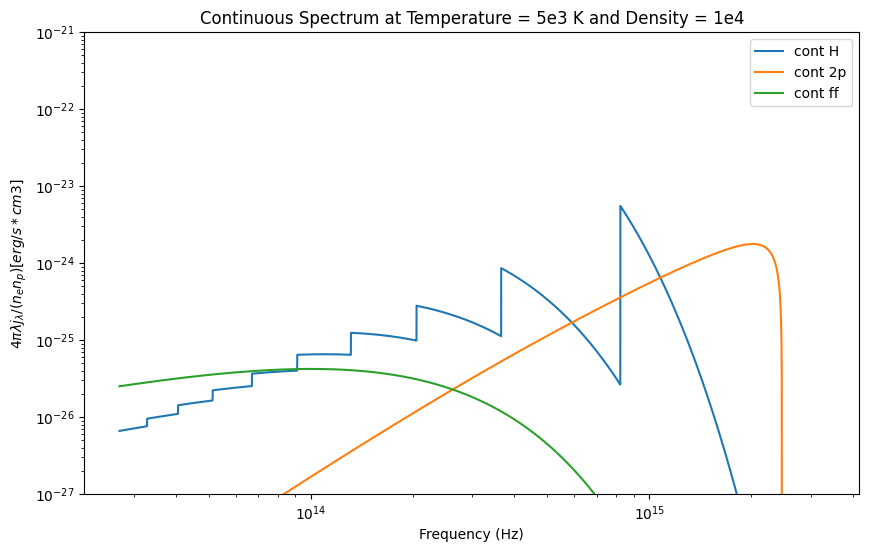

In [46]:
# Initialize continuum calculator and set redshift
C = pn.Continuum()
z = 10  # Cosmological redshift

# Create wavelength grid (83Å-10,000Å rest frame, redshifted)
wl = np.logspace(np.log10(83 * (1 + z)), np.log10(10000 * (1 + z)), 8000)  # Angstroms
c_light = 2.998 * 1e8  # m/s (will convert to Hz via ν = c/λ)

# Convert to frequency [Hz] - critical for energy conservation check
f = c_light / (wl * 1e-10)  # 1e-10 converts Å → meters

# Calculate continuum components at fixed T = 5000K, density = 1e4 cm^-3
density = 1e4  # cm^-3 (total density)
contH = C.get_continuum(tem = 5e3, den = density, wl = wl,  # Hydrogen bound-free
                       He1_H = 0, He2_H = 0, HI_label = None,
                       cont_HI = True, cont_HeI = True, cont_HeII = True,
                       cont_2p = False, cont_ff = False)

cont2p = C.get_continuum(tem = 5e3, den = density, wl = wl,  # Two-photon
                        He1_H = 0, He2_H = 0, HI_label = None,
                        cont_HI = False, cont_HeI = False, cont_HeII = False,
                        cont_2p = True, cont_ff = False)

contff = C.get_continuum(tem = 5e3, den = density, wl = wl,  # Free-free
                        He1_H = 0, He2_H = 0, HI_label = None,
                        cont_HI = False, cont_HeI = False, cont_HeII = False,
                        cont_2p = False, cont_ff = True)

# Plot λFλ vs frequency (energy-per-log-unit scaling)
plt.figure(figsize = (10, 6))
plt.plot(f, contH * wl, label = 'cont H')  # λFλ preserves spectral shape
plt.plot(f, cont2p * wl, label = 'cont 2p')
plt.plot(f, contff * wl, label = 'cont ff')

# Formatting (your original settings maintained)
plt.legend()
plt.ylim(1e-27, 1e-21)  # Characteristic range for these conditions
plt.xscale('log')  # Logarithmic frequency axis
plt.yscale('log')  # Logarithmic flux
plt.xlabel("Frequency (Hz)")  # ν = c/λ ensures correct energy distribution
plt.ylabel(r"$4\pi\lambda j_\lambda /(n_e n_p) [erg/s * cm3]$")  # Proportional to νFν
plt.title("Continuous Spectrum at Temperature = 5e3 K and Density = 1e4")
plt.show()

# Temperature Comparison of Continuum Spectra

Side-by-side comparison at fixed density = 10⁴ cm⁻³:  
- **Left**: T = 5,000 K  
- **Right**: T = 10,000 K  

All components plotted as λFλ vs frequency (ν = c/λ)

/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


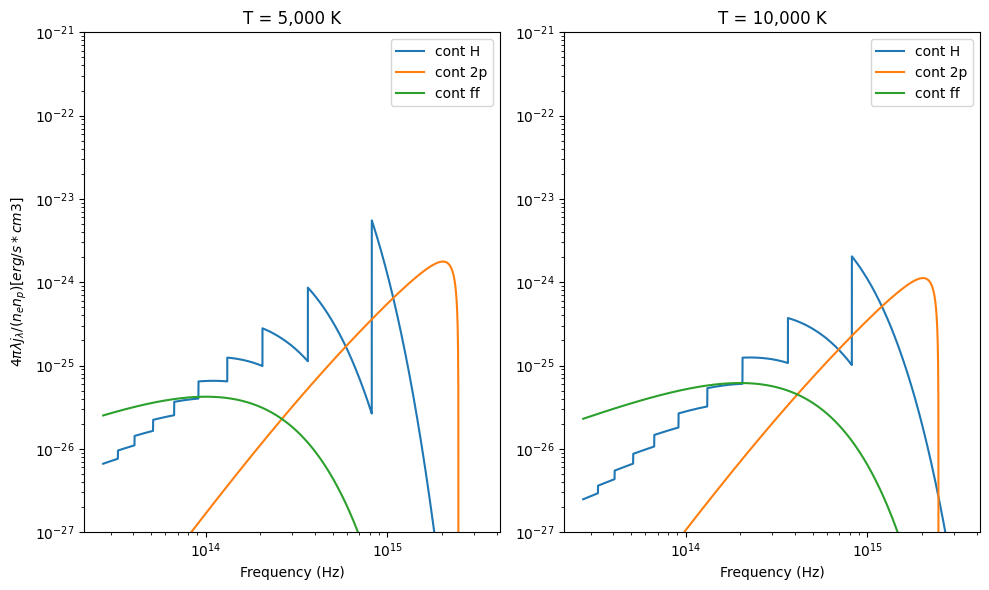

In [48]:
C = pn.Continuum()
z = 10
dense = 1e4
wl = np.logspace(np.log10(83 * (1 + z)), np.log10(10000 * (1 + z)), 8000)
c_light = 2.998 * 1e8 
f = c_light/(wl*1e-10)

contH_T5k = C.get_continuum(tem = 5e3, den = dense, He1_H = 0, He2_H = 0, wl = wl, HI_label = None, cont_HI=True, cont_HeI=True, cont_HeII=True, cont_2p=False, cont_ff=False)
cont2p_T5k = C.get_continuum(tem = 5e3, den = dense, He1_H = 0, He2_H = 0, wl = wl, HI_label = None, cont_HI=False, cont_HeI=False, cont_HeII=False, cont_2p=True, cont_ff=False)
contff_T5k = C.get_continuum(tem = 5e3, den = dense, He1_H = 0, He2_H = 0, wl = wl, HI_label = None, cont_HI=False, cont_HeI=False, cont_HeII=False, cont_2p=False, cont_ff=True)
contH_T10k = C.get_continuum(tem = 10e3, den = dense, He1_H = 0, He2_H = 0, wl = wl, HI_label = None, cont_HI=True, cont_HeI=True, cont_HeII=True, cont_2p=False, cont_ff=False)
cont2p_T10k = C.get_continuum(tem = 10e3, den = dense, He1_H = 0, He2_H = 0, wl = wl, HI_label = None, cont_HI=False, cont_HeI=False, cont_HeII=False, cont_2p=True, cont_ff=False)
contff_T10k = C.get_continuum(tem = 10e3, den = dense, He1_H = 0, He2_H = 0, wl = wl, HI_label = None, cont_HI=False, cont_HeI=False, cont_HeII=False, cont_2p=False, cont_ff=True)

# Create side-by-side subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))

# Plot 5,000 K on left
ax1.plot(f, contH_T5k * wl, label='cont H')
ax1.plot(f, cont2p_T5k * wl, label='cont 2p')
ax1.plot(f, contff_T5k * wl, label='cont ff')
ax1.set_title("T = 5,000 K")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(1e-27, 1e-21)
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel(r"$4\pi\lambda j_\lambda /(n_e n_p) [erg/s * cm3]$")
ax1.legend()

# Plot 10,000 K on right
ax2.plot(f, contH_T10k * wl, label='cont H')
ax2.plot(f, cont2p_T10k * wl, label='cont 2p')
ax2.plot(f, contff_T10k * wl, label='cont ff')
ax2.set_title("T = 10,000 K")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_ylim(1e-27, 1e-21)
ax2.set_xlabel("Frequency (Hz)")
ax2.legend()

plt.tight_layout()
plt.show()

# Density Dependence of Continuum Components

Comparing at fixed T = 5,000 K:  
- **Left**: density = 1 × 10⁴ cm⁻³  
- **Right**: density = 2 × 10⁴ cm⁻³  

/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


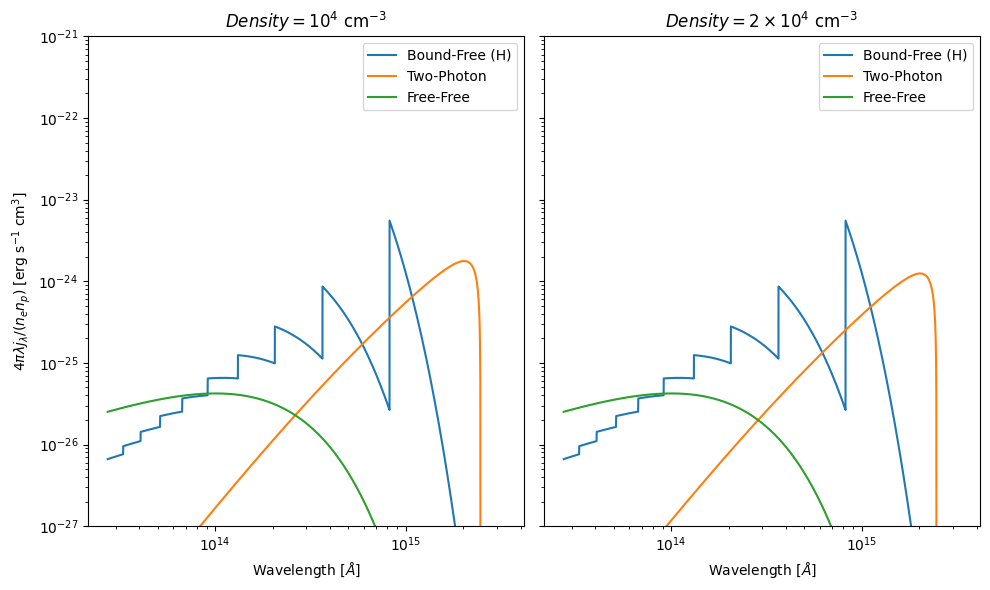

In [50]:
C = pn.Continuum()
z = 10
dense = 1e4
wl = np.logspace(np.log10(83 * (1 + z)), np.log10(10000 * (1 + z)), 8000)
c_light = 2.998 * 1e8 
f = c_light/(wl*1e-10)

# Calculate all components
components = {
    '1e4': {
        'contH': C.get_continuum(tem = 5e3, den = dense, wl = wl, HI_label = None, 
                                cont_HI = True, cont_HeI = False, cont_HeII = False,
                                cont_2p = False, cont_ff = False),
        'cont2p': C.get_continuum(tem = 5e3, den = dense, wl = wl, HI_label = None,
                                 cont_HI = False, cont_HeI = False, cont_HeII = False,
                                 cont_2p = True, cont_ff = False),
        'contff': C.get_continuum(tem = 5e3, den = dense, wl = wl, HI_label = None,
                                 cont_HI = False, cont_HeI = False, cont_HeII = False,
                                 cont_2p = False, cont_ff = True)
    },
    '2e4': {
        'contH': C.get_continuum(tem = 5e3, den = 2 * dense, wl = wl, HI_label = None, 
                                cont_HI = True, cont_HeI = False, cont_HeII = False,
                                cont_2p = False, cont_ff = False),
        'cont2p': C.get_continuum(tem = 5e3, den = 2 * dense, wl = wl, HI_label = None,
                                 cont_HI = False, cont_HeI = False, cont_HeII = False,
                                 cont_2p = True, cont_ff = False),
        'contff': C.get_continuum(tem = 5e3, den = 2 * dense, wl = wl, HI_label = None,
                                 cont_HI = False, cont_HeI = False, cont_HeII = False,
                                 cont_2p = False, cont_ff = True)
    }
}

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6), sharey = True)

# Plot density= 1e4 cm^-3
ax1.plot(f, components['1e4']['contH'] * wl, label = 'Bound-Free (H)')
ax1.plot(f, components['1e4']['cont2p'] * wl, label = 'Two-Photon')
ax1.plot(f, components['1e4']['contff'] * wl, label = 'Free-Free')
ax1.set_title(r"$Density = 10^4\ \mathrm{cm}^{-3}$")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel(r"Wavelength [$\AA$]")
ax1.set_ylabel(r"$4\pi\lambda j_\lambda/(n_e n_p)$ [erg s$^{-1}$ cm$^3$]")
ax1.legend()
ax1.set_ylim(1e-27, 1e-21)

# Plot density = 2e4 cm^-3
ax2.plot(f, components['2e4']['contH'] * wl, label = 'Bound-Free (H)')
ax2.plot(f, components['2e4']['cont2p'] * wl, label = 'Two-Photon')
ax2.plot(f, components['2e4']['contff'] * wl, label = 'Free-Free')
ax2.set_title(r"$Density = 2 \times 10^4\ \mathrm{cm}^{-3}$")
ax2.set_xscale('log')
ax2.set_xlabel(r"Wavelength [$\AA$]")
ax2.legend()

plt.tight_layout()
plt.show()

# JWST F200W Filter Analysis - Frequency Domain

**Frequency profile** of NIRCam's F200W filter:  
- Loaded from `F200W_filter.txt` (wavelength in μm → converted to frequency in Hz)  
- Output curve plotted against frequency with logarithmic scaling  
- Integral calculated with frequency weighting for normalization  

**Key Equations**:  
- Frequency conversion: ν = c/λ  
  where c = 2.998 × 10<sup>8</sup> m/s, λ in meters  
- Normalization integral: ∫(T(ν)/ν) dν  

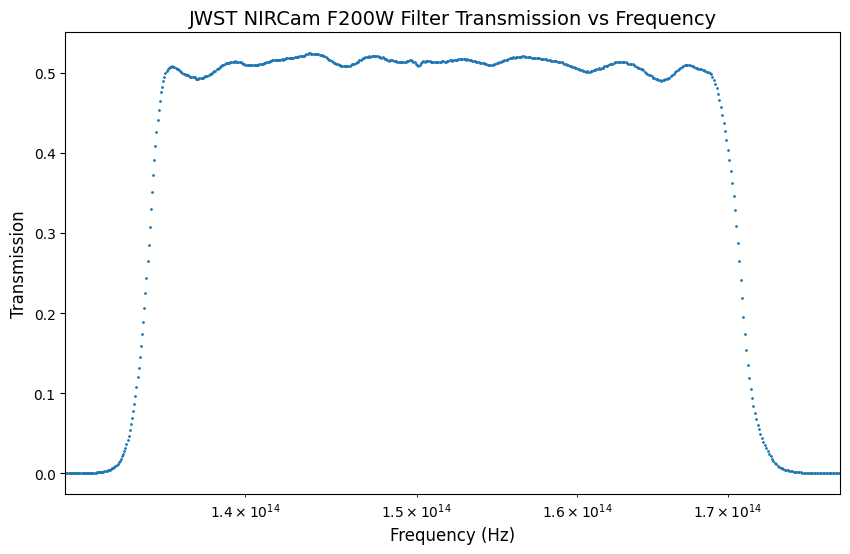

In [52]:
# Load filter data - file contains wavelength (microns) and transmission values
F200W = np.loadtxt('F200W_filter.txt', skiprows = 1)  # Skip header row

# Create DataFrame for better column handling
df_F200W = pd.DataFrame(F200W, columns = ['Wavelength [Microns]', 'Output'])

# Convert wavelength from microns to Angstroms (1 micron = 10,000 Angstroms)
wavelength_F200W = df_F200W['Wavelength [Microns]'] * 1e4  

# Speed of light in m/s (used for frequency conversion)
c_light = 2.998 * 1e8  

# Convert wavelength (in Angstroms) to frequency (in Hz)
# Note: 1 Angstrom = 1e-10 meters
frequency_F200W = c_light / (wavelength_F200W * 1e-10)  

# Get transmission values
output_F200W = df_F200W['Output']

# Calculate integral of filter response in frequency space
# We divide by frequency because of the ν^-1 factor when converting from wavelength
integral_filter_F200W_frequency = np.abs(np.trapz(output_F200W / frequency_F200W, frequency_F200W))

# Plot the filter transmission curve vs frequency
plt.figure(figsize = (10, 6))
plt.scatter(frequency_F200W, output_F200W, s = 1)

# Format plot
plt.xlim(np.min(frequency_F200W), np.max(frequency_F200W))
plt.xlabel('Frequency (Hz)', fontsize = 12)
plt.ylabel('Transmission', fontsize = 12)
plt.xscale('log')  # Log scale appropriate for broad frequency range
plt.title('JWST NIRCam F200W Filter Transmission vs Frequency', fontsize = 14)
plt.show()

# Analyzing Continuous Spectrum Through F200W Filter

**Observation of stellar continuum** at T = 5000 K with density n = 10<sup>4</sup> cm<sup>-3</sup>:
- Plotted hydrogen bound-free (`contH`), 2-photon (`cont2p`), and free-free (`contff`) emission components
- Overlaid F200W filter boundaries (red vertical lines) at:
  - ν<sub>min</sub> = `{:.2e}` Hz
  - ν<sub>max</sub> = `{:.2e}` Hz
- Y-axis shows normalized emissivity:  
  $\frac{4\pi\lambda j_\lambda}{n_e n_p}$ in erg s<sup>-1</sup> cm<sup>3</sup>

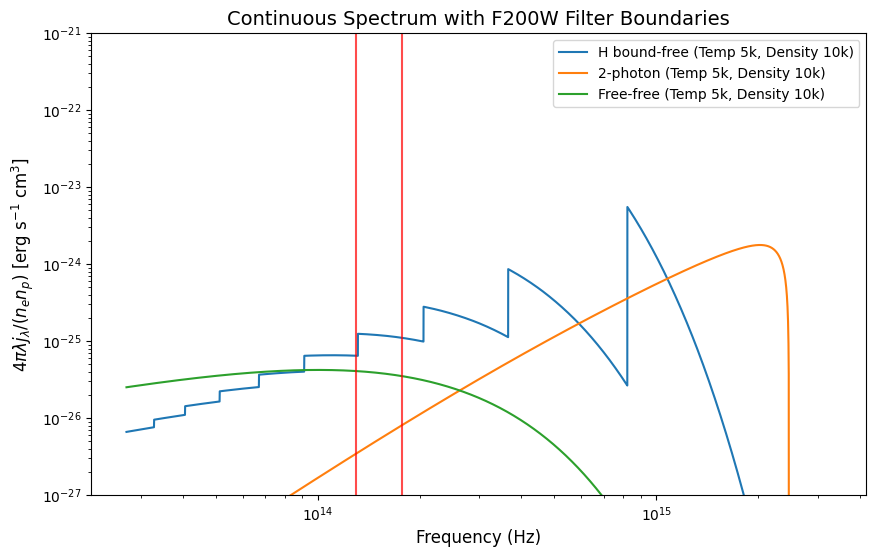

In [54]:
# Plot continuous spectrum components at T = 5000K, density = 1e4 cm^-3
plt.figure(figsize = (10, 6))
plt.plot(f, contH * wl, label = 'H bound-free (Temp 5k, Density 10k)')
plt.plot(f, cont2p * wl, label = '2-photon (Temp 5k, Density 10k)')
plt.plot(f, contff * wl, label = 'Free-free (Temp 5k, Density 10k)')

# Mark F200W filter frequency range
f_F200W_min = np.min(frequency_F200W)
f_F200W_max = np.max(frequency_F200W)
plt.axvline(x = f_F200W_min, color = 'red', linestyle = '-', alpha = 0.7)
plt.axvline(x = f_F200W_max, color = 'red', linestyle = '-', alpha = 0.7)

# Format plot
plt.legend(fontsize = 10)
plt.ylim(1e-27, 1e-21)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency (Hz)", fontsize = 12)
plt.ylabel(r"$4\pi\lambda j_\lambda /(n_e n_p) \ [\mathrm{erg \ s^{-1} \ cm^3}]$", fontsize = 12)
plt.title('Continuous Spectrum with F200W Filter Boundaries', fontsize = 14)

plt.show()

# Zoomed-In View of F200W Filter Bandpass

**Detailed spectrum within filter boundaries** (T = 5000 K, density = 10<sup>4</sup> cm<sup>-3</sup>):
- Frequency range: `{:.2e}` Hz to `{:.2e}` Hz
- Enhanced view of continuum processes:
  - Hydrogen bound-free (contH)
  - Two-photon (cont2p)
  - Free-free (contff)
- Y-axis range adjusted to `1e-27` to `1e-24` erg s<sup>-1</sup> cm<sup>3</sup>
- Prepares for flux integration through filter bandpass

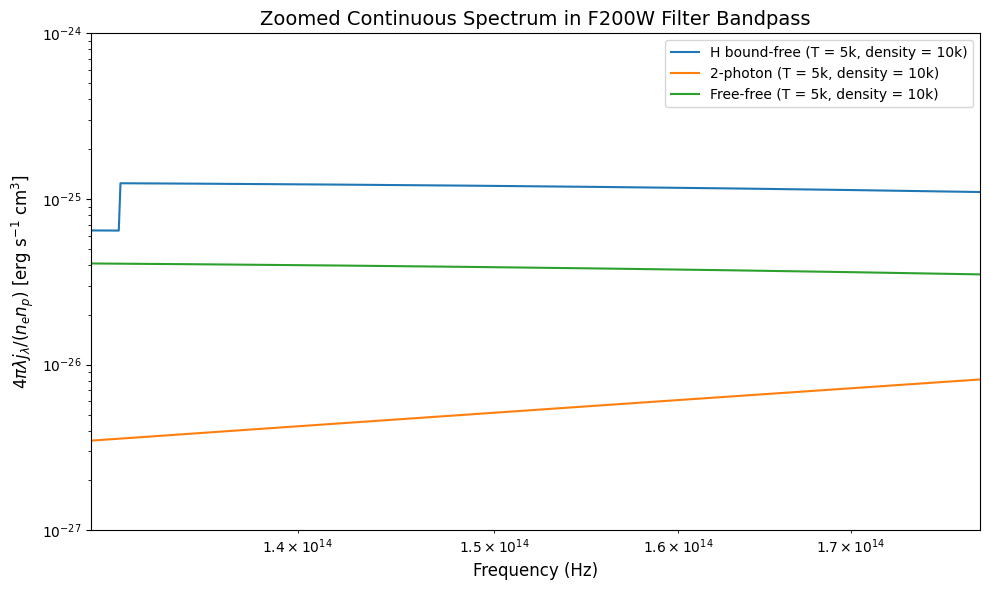

In [56]:
# Create zoomed-in plot of filter region
plt.figure(figsize = (10, 6))

# Apply frequency mask with small tolerance (1e-10 Hz)
tolerance = 1e-10
mask = (f >= f_F200W_min - tolerance) & (f <= f_F200W_max + tolerance)

# Plot continuum components within filter range
plt.plot(f[mask], contH[mask] * wl[mask], 
         label = 'H bound-free (T = 5k, density = 10k)')
plt.plot(f[mask], cont2p[mask] * wl[mask], 
         label = '2-photon (T = 5k, density = 10k)')
plt.plot(f[mask], contff[mask] * wl[mask], 
         label = 'Free-free (T = 5k, density = 10k)')

# Format plot
plt.legend(fontsize = 10, loc = 'upper right')
plt.xlim(f_F200W_min, f_F200W_max)
plt.ylim(1e-27, 1e-24)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency (Hz)", fontsize = 12)
plt.ylabel(r"$4\pi\lambda j_\lambda /(n_e n_p) \ [\mathrm{erg \ s^{-1} \ cm^3}]$", fontsize = 12)
plt.title('Zoomed Continuous Spectrum in F200W Filter Bandpass', fontsize = 14)

plt.tight_layout()
plt.show()

# Flux Averaging Through JWST F200W Filter (Frequency Domain)

**Filter-Weighted Flux Calculation**  
The average flux density $\langle f_\nu \rangle$ through the F200W filter in frequency space is computed using:

$$
\langle f_\nu \rangle = \frac{
    \int_{\nu_{\text{min}}}^{\nu_{\text{max}}} \frac{f_\nu(\nu) \cdot T(\nu)}{\nu} \,d\nu
}{
    \int_{\nu_{\text{min}}}^{\nu_{\text{max}}} \frac{T(\nu)}{\nu} \,d\nu
}
$$

**Flux Conversion Principle**:
- Conservation: $f_\lambda d\lambda = f_\nu d\nu$
- With $\lambda = c/\nu$ and $d\lambda = -\frac{c}{\nu^2}d\nu$:
  $$
  f_\nu = f_\lambda \frac{c}{\nu^2}
  $$

In [58]:
# Interpolation of the continuous spectrum in the filter range
fluxH_interp_frequency = interp1d(f[mask], contH[mask] * wl[mask]/f[mask]**2, kind = 'linear', fill_value = 'extrapolate')
flux2p_interp_frequency = interp1d(f[mask], cont2p[mask] * wl[mask]/f[mask]**2, kind = 'linear', fill_value = 'extrapolate')
fluxff_interp_frequency = interp1d(f[mask], contff[mask] * wl[mask]/f[mask]**2, kind = 'linear', fill_value = 'extrapolate')

outputH_interp_frequency = fluxH_interp_frequency(frequency_F200W)
output2p_interp_frequency = flux2p_interp_frequency(frequency_F200W)
outputff_interp_frequency = fluxff_interp_frequency(frequency_F200W)

result_contH_frequency = outputH_interp_frequency * output_F200W
result_cont2p_frequency = output2p_interp_frequency * output_F200W
result_contff_frequency = outputff_interp_frequency * output_F200W

# Integrate the result by using continuum * output/frequency d(frequency)
integral_contH_frequency = np.abs(np.trapz(result_contH_frequency, frequency_F200W))
integral_cont2p_frequency = np.abs(np.trapz(result_cont2p_frequency, frequency_F200W))
integral_contff_frequency = np.abs(np.trapz(result_contff_frequency, frequency_F200W))

# Calculating Flux Average
flux_avg_contH_frequency = integral_contH_frequency/integral_filter_F200W_frequency
flux_avg_cont2p_frequency = integral_cont2p_frequency/integral_filter_F200W_frequency
flux_avg_contff_frequency = integral_contff_frequency/integral_filter_F200W_frequency

# Show the result
print(f"The flux average of H is {flux_avg_contH_frequency}")
print(f"The flux average of 2p is {flux_avg_cont2p_frequency}")
print(f"The flux average of ff is {flux_avg_contff_frequency}")

The flux average of H is 7.895508235643549e-40
The flux average of 2p is 3.5046164103211626e-41
The flux average of ff is 2.549930336103158e-40


# JWST F200W Flux Analysis in Frequency Domain

**Filter-weighted flux calculations** across parameter space for:
- Hydrogen bound-free (`contH`)
- Two-photon (`cont2p`)  
- Free-free (`contff`) emission

**Key Parameters**:
- Temperature range: 1,000K–100,000K (log-spaced)
- Density range: 1e-28–1e5 cm⁻³ (log-spaced)  
- Redshift: z=10 → Observed frame wavelengths shifted by (1+z)
- Frequency range: `{:.2e}`–`{:.2e}` Hz (corresponding to 83–10,000Å rest frame)

**Frequency-Domain Implementation**:
1. Wavelength-to-frequency conversion: $\nu = c/\lambda$
2. Flux conversion: $f_\nu = f_\lambda \cdot \lambda^2/c$ (preserving $f_\lambda d\lambda = f_\nu d\nu$)
3. Filter transmission weighted by $\nu^{-1}$ in normalization integral

**Output DataFrame** contains:
- Temperature & density parameters  
- Normalized flux averages (∝ nₚnₑ) for each component
- All values calculated in frequency space

In [60]:
# Parameter space setup
temperature = np.logspace(3, 5, 10)  # 1,000K to 100,000K (log-spaced)
density = np.logspace(-28, 5, 10)    # 1e-28 to 1e5 cm^-3 (log-spaced)
z = 10                               # Redshift
c_light = 2.998 * 1e8               # m/s

# Wavelength grid (rest frame 83-10000Å, redshifted)
wl = np.logspace(np.log10(83 * (1 + z)), np.log10(10000 * (1 + z)), 8000, dtype = np.float64)
f = c_light / (wl * 1e-10)          # Convert to frequency (Hz)

# Load filter data
F200W = np.loadtxt('F200W_filter.txt', skiprows = 1)
wl_F200W = F200W[:, 0] * 1e4        # microns→Angstrom
f_F200W = c_light / (wl_F200W * 1e-10)  # Filter frequencies (Hz)
output_F200W = F200W[:, 1]          # Transmission values

# Filter normalization integral (∫T(ν)/ν dν)
integral_filter_F200W_f = np.abs(np.trapz(output_F200W / f_F200W, f_F200W))

# Frequency masking
f_F200W_min, f_F200W_max = f_F200W.min(), f_F200W.max()
tolerance = 1e-10
mask_f = (f >= f_F200W_min - tolerance) & (f <= f_F200W_max + tolerance)

# Initialize results storage
results_frequency = []

# Main calculation loop (temperature × density grid)
for tem in temperature:
    for den in density:
        # Get continuum components (with ALL original parameters)
        contH = C.get_continuum(tem = tem, den = den, He1_H = 0, He2_H = 0, wl = wl, HI_label = None,
                               cont_HI = True, cont_HeI = True, cont_HeII = True, cont_2p = False, cont_ff = False)
        cont2p = C.get_continuum(tem = tem, den = den, He1_H = 0, He2_H = 0, wl = wl, HI_label = None,
                                cont_HI = False, cont_HeI = False, cont_HeII = False, cont_2p = True, cont_ff = False)
        contff = C.get_continuum(tem = tem, den = den, He1_H = 0, He2_H = 0, wl = wl, HI_label = None,
                                cont_HI = False, cont_HeI = False, cont_HeII = False, cont_2p = False, cont_ff = True)

        # Interpolate and apply filter
        fluxH_interp_f = interp1d(f[mask_f], contH[mask_f] * wl[mask_f] / f[mask_f]**2, kind = 'linear', fill_value = 'extrapolate')
        outputH_interp_f = fluxH_interp_f(f_F200W)
        result_contH_f = outputH_interp_f * output_F200W

        # Repeat for other components
        flux2p_interp_f = interp1d(f[mask_f], cont2p[mask_f] * wl[mask_f] / f[mask_f]**2, kind = 'linear', fill_value = 'extrapolate')
        output2p_interp_f = flux2p_interp_f(f_F200W)
        result_cont2p_f = output2p_interp_f * output_F200W

        fluxff_interp_f = interp1d(f[mask_f], contff[mask_f] * wl[mask_f] / f[mask_f]**2, kind = 'linear', fill_value = 'extrapolate')
        outputff_interp_f = fluxff_interp_f(f_F200W)
        result_contff_f = outputff_interp_f * output_F200W

        # Integrate filtered flux
        integral_contH_f = np.abs(np.trapz(result_contH_f, f_F200W))
        integral_cont2p_f = np.abs(np.trapz(result_cont2p_f, f_F200W))
        integral_contff_f = np.abs(np.trapz(result_contff_f, f_F200W))

        # Normalize by filter integral
        flux_avg_contH_f = integral_contH_f / integral_filter_F200W_f
        flux_avg_cont2p_f = integral_cont2p_f / integral_filter_F200W_f
        flux_avg_contff_f = integral_contff_f / integral_filter_F200W_f

        # Store results
        results_frequency.append({
            'Temperature': tem,
            'Density': den,
            'Flux_avg_contH': flux_avg_contH_f,
            'Flux_avg_cont2p': flux_avg_cont2p_f,
            'Flux_avg_contff': flux_avg_contff_f
        })

# Create final DataFrame
df_results_frequency = pd.DataFrame(results_frequency)

# Show the result
df_results_frequency

/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


,Temperature,Density,Flux_avg_contH,Flux_avg_cont2p,Flux_avg_contff
0,1000.0,1.000000e-28,2.445103e-39,1.952505e-40,1.793087e-42
1,1000.0,4.641589e-25,2.445103e-39,1.952505e-40,1.793087e-42
2,1000.0,2.154435e-21,2.445103e-39,1.952505e-40,1.793087e-42
3,1000.0,1.000000e-17,2.445103e-39,1.952505e-40,1.793087e-42
4,1000.0,4.641589e-14,2.445103e-39,1.952505e-40,1.793087e-42
...,...,...,...,...,...
95,100000.0,2.154435e-10,1.587907e-41,6.832697e-42,3.670252e-40
96,100000.0,1.000000e-06,1.587907e-41,6.832697e-42,3.670252e-40
97,100000.0,4.641589e-03,1.587907e-41,6.832695e-42,3.670252e-40
98,100000.0,2.154435e+01,1.587907e-41,6.826278e-42,3.670252e-40


# Verification of Frequency-Domain Calculations

**Purpose**: Validate that the loop results match direct calculations for:  
- Temperature = 100,000 K  
- Density = 21.54435 cm⁻³  

**Method**:  
1. Compute continuum components directly using `C.get_continuum()`  
2. Interpolate onto filter frequencies  
3. Compare with DataFrame results at index 98  
4. Check differences with 10% tolerance  

In [62]:
# Direct frequency-domain calculation
temp_check = 1e5
dense_check = 21.54435

# Get continuum components
contH_check = C.get_continuum(tem = temp_check, den = dense_check, He1_H = 0, He2_H = 0, 
                             wl = wl, HI_label = None, cont_HI = True, cont_HeI = True,
                             cont_HeII = True, cont_2p = False, cont_ff = False)
cont2p_check = C.get_continuum(tem = temp_check, den = dense_check, He1_H = 0, He2_H = 0,
                              wl = wl, HI_label = None, cont_HI = False, cont_HeI = False,
                              cont_HeII = False, cont_2p = True, cont_ff = False)
contff_check = C.get_continuum(tem = temp_check, den = dense_check, He1_H = 0, He2_H = 0,
                              wl = wl, HI_label = None, cont_HI = False, cont_HeI = False,
                              cont_HeII = False, cont_2p = False, cont_ff = True)

# Frequency-domain interpolation and integration
fluxH_interp_freq = interp1d(f[mask], contH_check[mask] * wl[mask] / f[mask]**2, 
                       kind = 'linear', fill_value = 'extrapolate')
result_contH_freq = fluxH_interp_freq(frequency_F200W) * output_F200W
flux_avg_contH_freq = np.abs(np.trapz(result_contH_freq, frequency_F200W)) / integral_filter_F200W_frequency

flux2p_interp_freq = interp1d(f[mask], cont2p_check[mask] * wl[mask] / f[mask]**2,
                        kind = 'linear', fill_value = 'extrapolate')
result_cont2p_freq = flux2p_interp_freq(frequency_F200W) * output_F200W
flux_avg_cont2p_freq = np.abs(np.trapz(result_cont2p_freq, frequency_F200W)) / integral_filter_F200W_frequency

fluxff_interp_freq = interp1d(f[mask], contff_check[mask] * wl[mask] / f[mask]**2,
                        kind = 'linear', fill_value = 'extrapolate')
result_contff_freq = fluxff_interp_freq(frequency_F200W) * output_F200W
flux_avg_contff_freq = np.abs(np.trapz(result_contff_freq, frequency_F200W)) / integral_filter_F200W_frequency

# Comparison with dataframe
flux_avg_contH_df_freq = df_results_frequency['Flux_avg_contH'][98]
flux_avg_cont2p_df_freq = df_results_frequency['Flux_avg_cont2p'][98]
flux_avg_contff_df_freq = df_results_frequency['Flux_avg_contff'][98]

# Results
print("[Frequency-Domain Verification]")
print(f"H  flux (ν): Direct = {flux_avg_contH_freq:.3e} | DF = {flux_avg_contH_df_freq:.3e} | Δ = {np.abs(flux_avg_contH_freq - flux_avg_contH_df_freq):.1e}")
print(f"2p flux (ν): Direct = {flux_avg_cont2p_freq:.3e} | DF = {flux_avg_cont2p_df_freq:.3e} | Δ = {np.abs(flux_avg_cont2p_freq - flux_avg_cont2p_df_freq):.1e}")
print(f"ff flux (ν): Direct = {flux_avg_contff_freq:.3e} | DF = {flux_avg_contff_df_freq:.3e} | Δ = {np.abs(flux_avg_contff_freq - flux_avg_contff_df_freq):.1e}")

# Validation
tolerance_passed = (
    np.isclose(flux_avg_contH_freq, flux_avg_contH_df_freq, rtol = 0.1) and
    np.isclose(flux_avg_cont2p_freq, flux_avg_cont2p_df_freq, rtol = 0.1) and
    np.isclose(flux_avg_contff_freq, flux_avg_contff_df_freq, rtol = 0.1)
)

print("\n" + ("FREQUENCY-DOMAIN VERIFICATION PASSED" if tolerance_passed else "VERIFICATION FAILED"))

[Frequency-Domain Verification]
H  flux (ν): Direct = 1.588e-41 | DF = 1.588e-41 | Δ = 0.0e+00
2p flux (ν): Direct = 6.826e-42 | DF = 6.826e-42 | Δ = 9.2e-52
ff flux (ν): Direct = 3.670e-40 | DF = 3.670e-40 | Δ = 0.0e+00

FREQUENCY-DOMAIN VERIFICATION PASSED


/opt/anaconda3/lib/python3.12/site-packages/pyneb/core/continuum.py:135: RuntimeWarning: invalid value encountered in power
  A = 202.0 * (y * (1. - y) * (1. -(4. * y * (1 - y))**0.8) + 0.88 * ( y * (1 - y))**1.53 * (4. * y * (1 - y))**0.8)


# Wavelength-Frequency Flux Conversion Check

**Validation** of flux unit conversion using $f_\lambda \lambda = f_\nu \nu$ with $\nu = c/\lambda$:  

**Key Parameters**:  
- Pivot wavelength: $1.988 \mu m$ (F200W filter)  
- Speed of light: $c = 2.998 \times 10^8 m/s$  

**Conversion Formula**:  
$$
f_\nu = f_\lambda \cdot \frac{\lambda_{pivot}^2}{c}
$$

**Purpose**:  
Verify consistency between wavelength-domain and frequency-domain flux averages

In [64]:
# Wavelength-to-frequency conversion
wl_pivot = 1.988e-6  # F200W pivot wavelength [m]
wl_pivot_A = 1.988 * 1e4  # Convert to Angstroms [Å]
c_light = 2.998e8  # Speed of light [m/s]
f_pivot = c_light / wl_pivot  # Corresponding frequency [Hz]

# Convert wavelength-domain results to frequency-domain using fν = fλ × λ²/c
flux_avg_contH_freq_converted = flux_avg_contH_wl * (wl_pivot_A * wl_pivot / c_light)
flux_avg_cont2p_freq_converted = flux_avg_cont2p_wl * (wl_pivot_A * wl_pivot / c_light)
flux_avg_contff_freq_converted = flux_avg_contff_wl * (wl_pivot_A * wl_pivot / c_light)

# Frequency-domain results from direct calculation
flux_avg_contH_freq_direct = flux_avg_contH_freq
flux_avg_cont2p_freq_direct = flux_avg_cont2p_freq
flux_avg_contff_freq_direct = flux_avg_contff_freq

# Result comparison
print("[Wavelength-to-Frequency Conversion Check]")
print("Method 1: Direct frequency calculation")
print("Method 2: Wavelength-to-frequency conversion")
print("\nHydrogen Continuum:")
print(f"Direct (ν): {flux_avg_contH_freq_direct:.3e} | Converted: {flux_avg_contH_freq_converted:.3e}")

print("\nTwo-Photon Continuum:")
print(f"Direct (ν): {flux_avg_cont2p_freq_direct:.3e} | Converted: {flux_avg_cont2p_freq_converted:.3e}")

print("\nFree-Free Continuum:")
print(f"Direct (ν): {flux_avg_contff_freq_direct:.3e} | Converted: {flux_avg_contff_freq_converted:.3e}")

# Difference analysis
print("\n[Absolute Differences]")
print(f"contH: {np.abs(flux_avg_contH_freq_direct - flux_avg_contH_freq_converted):.2e}")
print(f"cont2p: {np.abs(flux_avg_cont2p_freq_direct - flux_avg_cont2p_freq_converted):.2e}")
print(f"contff: {np.abs(flux_avg_contff_freq_direct - flux_avg_contff_freq_converted):.2e}")

# Final validation
validation_passed = (
    np.isclose(flux_avg_contH_freq_direct, flux_avg_contH_freq_converted, atol = 0.1*flux_avg_contH_freq_converted) and
    np.isclose(flux_avg_cont2p_freq_direct, flux_avg_cont2p_freq_converted, atol = 0.1*flux_avg_cont2p_freq_converted) and
    np.isclose(flux_avg_contff_freq_direct, flux_avg_contff_freq_converted, atol = 0.1*flux_avg_contff_freq_converted)
)

print("\nValidation Status:", "CONVERSION VALID" if validation_passed else "CONVERSION INVALID")

[Wavelength-to-Frequency Conversion Check]
Method 1: Direct frequency calculation
Method 2: Wavelength-to-frequency conversion

Hydrogen Continuum:
Direct (ν): 1.588e-41 | Converted: 1.589e-41

Two-Photon Continuum:
Direct (ν): 6.826e-42 | Converted: 6.830e-42

Free-Free Continuum:
Direct (ν): 3.670e-40 | Converted: 3.672e-40

[Absolute Differences]
contH: 7.97e-45
cont2p: 3.43e-45
contff: 1.84e-43

Validation Status: CONVERSION VALID


# Data Extraction and Interpolation Setup

**Purpose**: Prepare interpolation functions from dataframe results  
**Process**:
1. Extract temperature, density, and flux values
2. Create 2D interpolation points
3. Initialize interpolators for each flux type

In [66]:
# Data extraction
temperature = df_results['Temperature'].values
density = df_results['Density'].values
flux_avg_contH = df_results['Flux_avg_contH'].values
flux_avg_cont2p = df_results['Flux_avg_cont2p'].values
flux_avg_contff = df_results['Flux_avg_contff'].values

# Interpolation setup
points = np.column_stack((temperature, density))
interp_func_contH = LinearNDInterpolator(points, flux_avg_contH)
interp_func_cont2p = LinearNDInterpolator(points, flux_avg_cont2p)
interp_func_contff = LinearNDInterpolator(points, flux_avg_contff)

# Field Calculation Functions

**Maintains** for each flux type:  
- Temperature clipping (1000-100000K)  
- Validity checking  
- NaN handling  
- Array reshaping

In [68]:
# ContH field function
def _flux_contH_field(field, data):
    temperature = data['gas', 'temperature'].value
    density = data['gas', 'density'].value
    
    temperature = np.clip(temperature, 1000, 1e5)
    valid_mask = np.isfinite(temperature) & np.isfinite(density)
    temperature = temperature[valid_mask]
    density = density[valid_mask]
    
    points = np.column_stack((temperature.flatten(), density.flatten()))
    flux_contH = interp_func_contH(points)
    flux_contH[np.isnan(flux_contH)] = 1e-35
    
    return flux_contH.reshape(temperature.shape)

# Cont2p function
def _flux_cont2p_field(field, data):
    temperature = data['gas', 'temperature'].value
    density = data['gas', 'density'].value
    
    temperature = np.clip(temperature, 1000, 1e5)
    valid_mask = np.isfinite(temperature) & np.isfinite(density)
    temperature = temperature[valid_mask]
    density = density[valid_mask]
    
    points = np.column_stack((temperature.flatten(), density.flatten()))
    flux_cont2p = interp_func_cont2p(points)
    flux_cont2p[np.isnan(flux_cont2p)] = 1e-35
    
    return flux_cont2p.reshape(temperature.shape)

# Contff function
def _flux_contff_field(field, data):
    temperature = data['gas', 'temperature'].value
    density = data['gas', 'density'].value
    
    temperature = np.clip(temperature, 1000, 1e5)
    valid_mask = np.isfinite(temperature) & np.isfinite(density)
    temperature = temperature[valid_mask]
    density = density[valid_mask]
    
    points = np.column_stack((temperature.flatten(), density.flatten()))
    flux_contff = interp_func_contff(points)
    flux_contff[np.isnan(flux_contff)] = 1e-35
    
    return flux_contff.reshape(temperature.shape)

# Field Registration

**Adds All Three Fields** to yt dataset with:  
- Consistent sampling type  
- Unit: Empty Unit
- Force override enabled

In [70]:
# Add field to ds
ds.add_field(
    ("gas", "flux_contH"),
    function = _flux_contH_field,
    sampling_type = "cell",
    units = "",
    force_override = True
)

ds.add_field(
    ("gas", "flux_cont2p"),
    function = _flux_cont2p_field,
    sampling_type = "cell",
    units = "",
    force_override = True
)

ds.add_field(
    ("gas", "flux_contff"),
    function = _flux_contff_field,
    sampling_type = "cell",
    units = "",
    force_override = True
)

## Show Projection Plot After Adding the Field

yt : [INFO     ] 2025-04-03 22:08:25,151 Projection completed
yt : [INFO     ] 2025-04-03 22:08:25,153 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 22:08:25,153 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 22:08:25,155 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 22:08:25,156 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 22:08:25,156 Making a fixed resolution buffer of (('gas', 'flux_contH')) 800 by 800



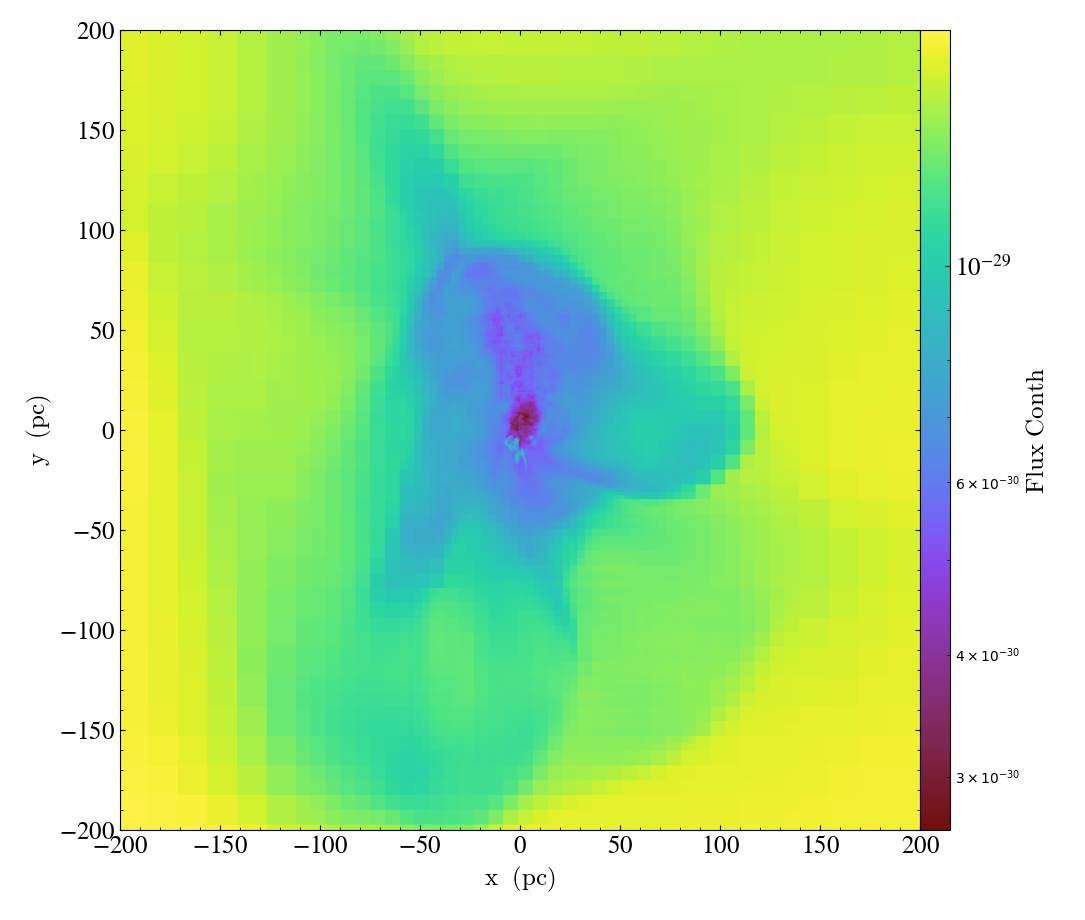

In [72]:
# contH plot
yt.ProjectionPlot(
    ds,
    "z",
    ("gas", "flux_contH"),
    width = (plt_wdth, "pc"),
    weight_field = ("gas", "density"),
    center = ctr_at_code
)

yt : [INFO     ] 2025-04-03 22:08:30,201 Projection completed
yt : [INFO     ] 2025-04-03 22:08:30,202 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 22:08:30,202 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 22:08:30,204 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 22:08:30,204 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 22:08:30,204 Making a fixed resolution buffer of (('gas', 'flux_cont2p')) 800 by 800



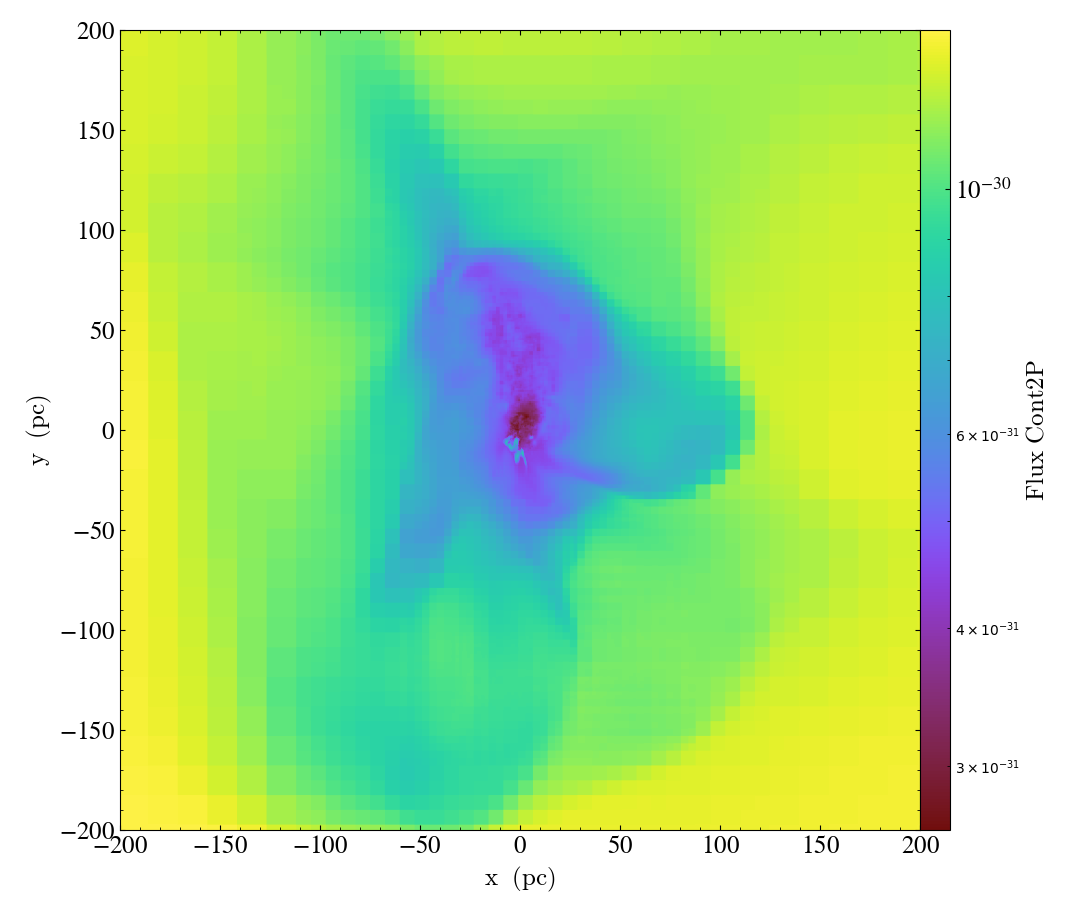

In [73]:
# cont2p plot
yt.ProjectionPlot(
    ds,
    "z",
    ("gas", "flux_cont2p"),
    width = (plt_wdth, "pc"),
    weight_field = ("gas", "density"),
    center = ctr_at_code
)

yt : [INFO     ] 2025-04-03 22:08:35,212 Projection completed
yt : [INFO     ] 2025-04-03 22:08:35,214 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 22:08:35,214 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 22:08:35,216 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 22:08:35,216 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 22:08:35,216 Making a fixed resolution buffer of (('gas', 'flux_contff')) 800 by 800



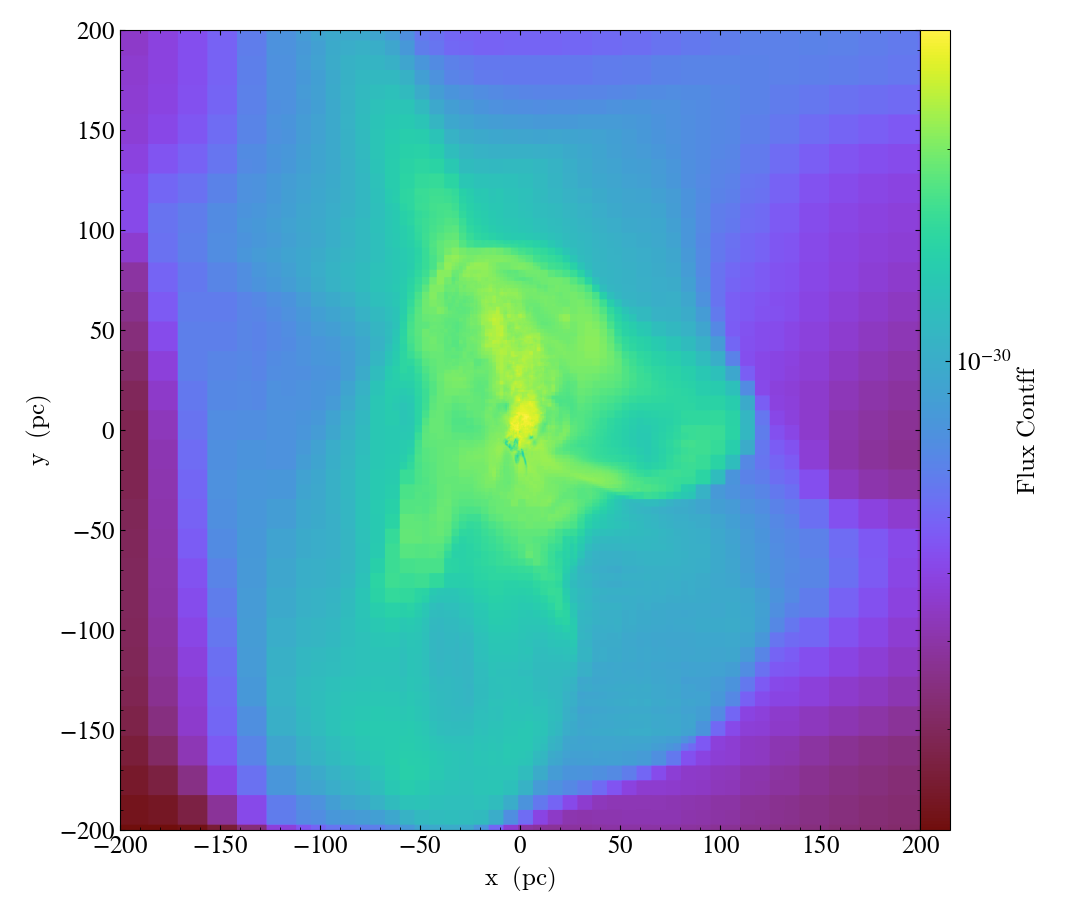

In [74]:
# contff plot
yt.ProjectionPlot(
    ds,
    "z",
    ("gas", "flux_contff"),
    width = (plt_wdth, "pc"),
    weight_field = ("gas", "density"),
    center = ctr_at_code
)

# 2D Histograms of Flux Fields vs Density-Temperature

This analysis creates three side-by-side 2D histograms showing the relationship between gas density, temperature, and three different flux fields:

1.  **flux_contH**: Continuum flux from H  
2.  **flux_cont2p**: Continuum flux from 2-photon processes  
3.  **flux_contff**: Continuum free-free flux  

Each plot shows the mean flux value in each density-temperature bin.

yt : [INFO     ] 2025-04-03 22:08:40,407 Projection completed
yt : [INFO     ] 2025-04-03 22:08:40,414 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 22:08:40,415 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 22:08:40,424 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 22:08:40,425 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 22:08:40,425 Making a fixed resolution buffer of (('gas', 'flux_contH')) 800 by 800
yt : [INFO     ] 2025-04-03 22:08:45,174 Projection completed
yt : [INFO     ] 2025-04-03 22:08:45,174 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 22:08:45,175 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 22:08:45,176 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 22:08:45,176 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 22:08:45,177 Making a fixed resolution buffer of (('gas', 'flux_cont2p')) 800 by 800
yt : [INFO     ] 2025-04-03 22:08:49,904 Projection completed
yt : [INFO     ] 2025-04-03 22:08:49,907 xlim = 0.491120 0.49

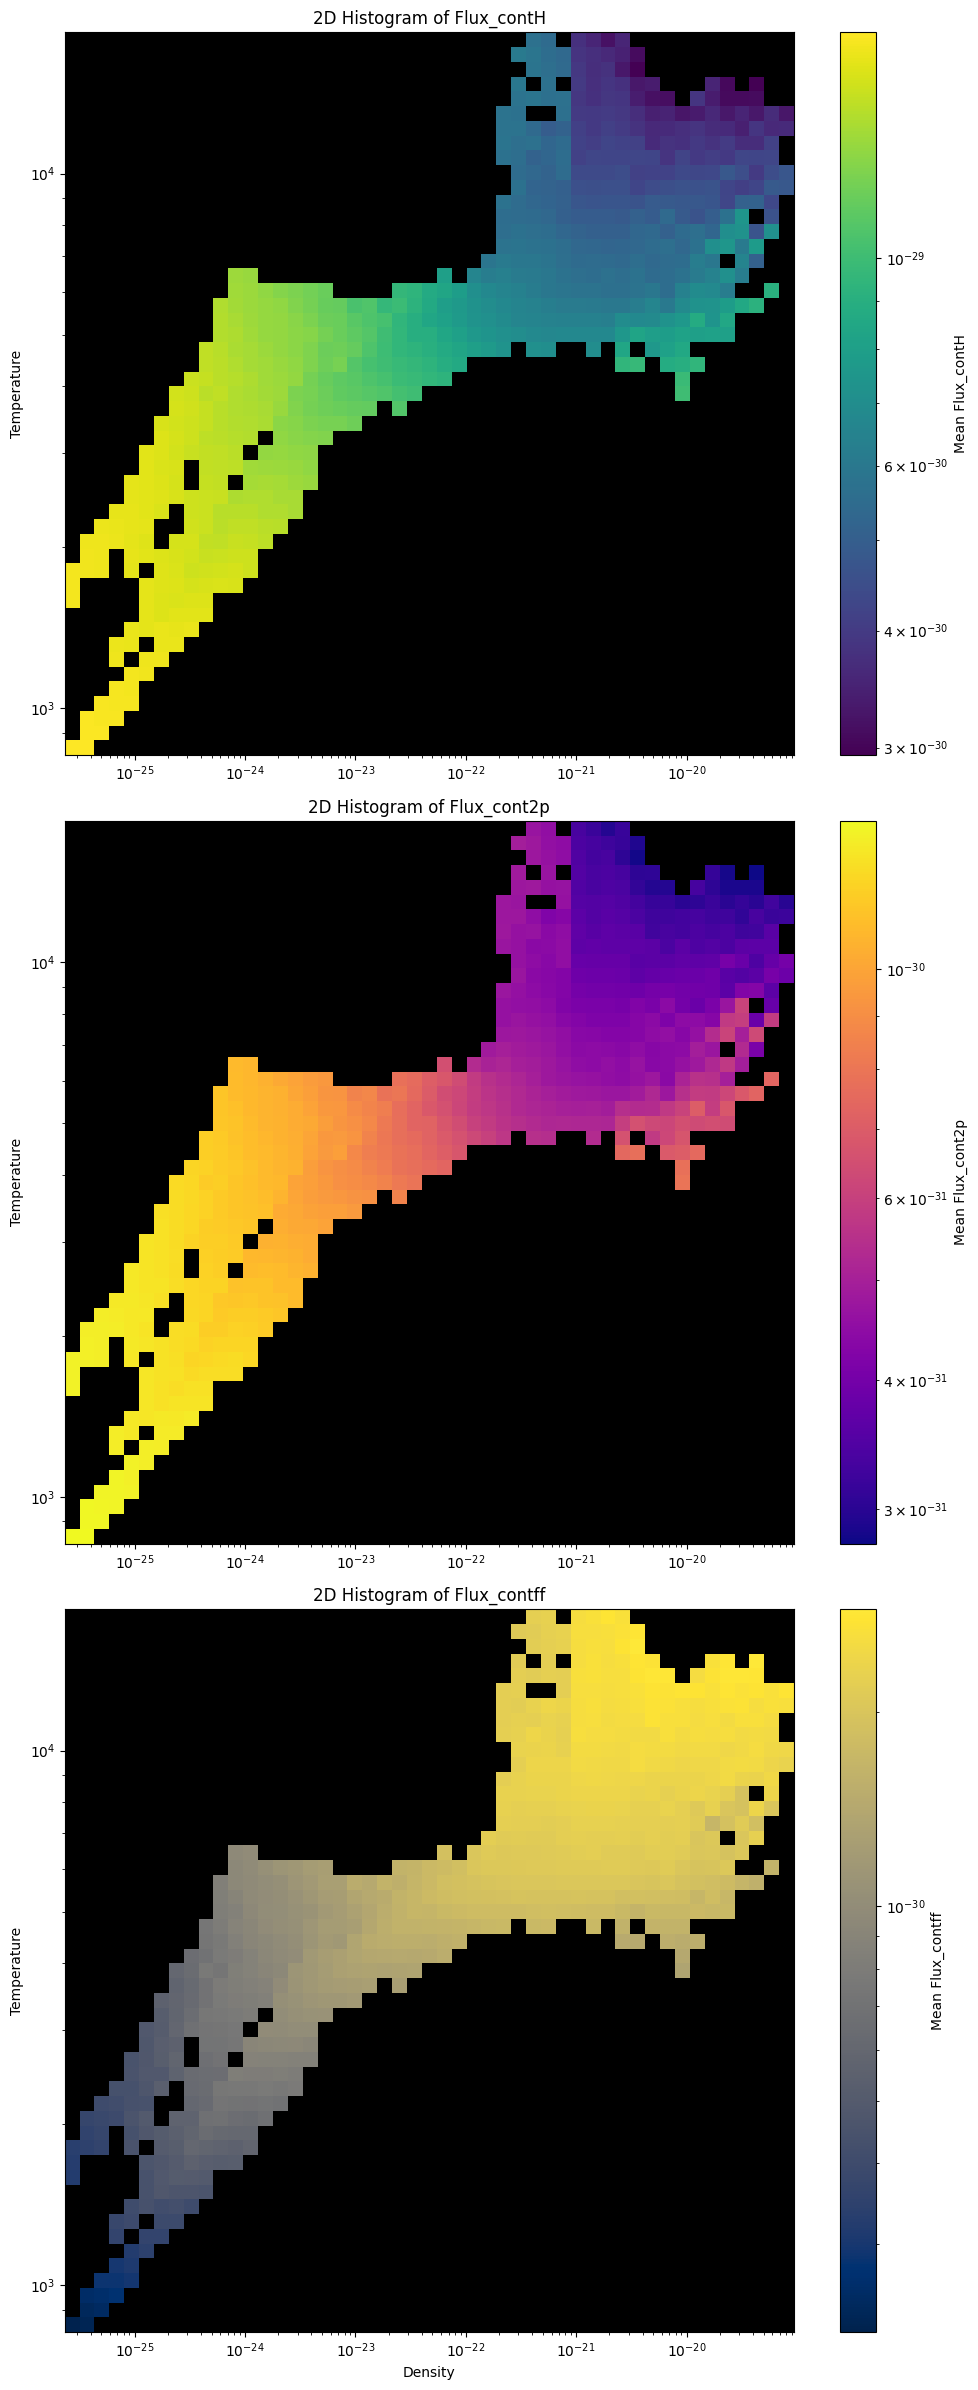

In [76]:
# Create projection plots for each field
p_H = yt.ProjectionPlot(
    ds,
    "z",
    ("gas", "flux_contH"),
    width = (plt_wdth, "pc"),
    weight_field = ("gas", "density"),
    center = ctr_at_code
)

p_2p = yt.ProjectionPlot(
    ds,
    "z",
    ("gas", "flux_cont2p"),
    width = (plt_wdth, "pc"),
    weight_field = ("gas", "density"),
    center = ctr_at_code
)

p_ff = yt.ProjectionPlot(
    ds,
    "z",
    ("gas", "flux_contff"),
    width = (plt_wdth, "pc"),
    weight_field = ("gas", "density"),
    center = ctr_at_code
)

# Get fixed resolution buffers for each field
frb_H = p_H.frb
frb_2p = p_2p.frb
frb_ff = p_ff.frb

# Extract fields from their respective FRBs
flux_contH = frb_H["gas", "flux_contH"].value.flatten()
flux_cont2p = frb_2p["gas", "flux_cont2p"].value.flatten()
flux_contff = frb_ff["gas", "flux_contff"].value.flatten()

# Get density and temperature
density = frb_H["gas", "density"].value.flatten()
temperature = frb_H["gas", "temperature"].value.flatten()

# Handle NaNs
flux_contH = np.where(np.isnan(flux_contH), 1e-35, flux_contH)
flux_cont2p = np.where(np.isnan(flux_cont2p), 1e-35, flux_cont2p)
flux_contff = np.where(np.isnan(flux_contff), 1e-35, flux_contff)

# Create bins
density_bins = np.logspace(np.log10(np.min(density)), np.log10(np.max(density)), num = 50)
temperature_bins = np.logspace(np.log10(np.min(temperature)), np.log10(np.max(temperature)), num = 50)

# Common counts
counts, _, _ = np.histogram2d(density, temperature, bins = [density_bins, temperature_bins])

# Create figure with 3 vertical subplots
plt.figure(figsize = (10, 24))

# Plot 1: flux_contH
plt.subplot(3, 1, 1)
hist_H, xedges, yedges = np.histogram2d(
    density,
    temperature,
    bins = [density_bins, temperature_bins],
    weights = flux_contH
)
hist_norm_H = np.where(counts > 0, hist_H / counts, 0)
masked_H = np.ma.masked_less_equal(hist_norm_H.T, 1e-35)
plot_H = plt.pcolormesh(xedges, yedges, masked_H, norm = LogNorm(), cmap = "viridis")
plot_H.cmap.set_bad('black')
plt.colorbar(label = "Mean Flux_contH")
plt.xscale("log")
plt.yscale("log")
plt.xlim(np.min(density), np.max(density))
plt.ylim(np.min(temperature), np.max(temperature))
plt.ylabel("Temperature")
plt.title("2D Histogram of Flux_contH")

# Plot 2: flux_cont2p
plt.subplot(3, 1, 2)
hist_2p, _, _ = np.histogram2d(
    density,
    temperature,
    bins = [density_bins, temperature_bins],
    weights = flux_cont2p
)
hist_norm_2p = np.where(counts > 0, hist_2p / counts, 0)
masked_2p = np.ma.masked_less_equal(hist_norm_2p.T, 1e-35)
plot_2p = plt.pcolormesh(xedges, yedges, masked_2p, norm = LogNorm(), cmap = "plasma")
plot_2p.cmap.set_bad('black')
plt.colorbar(label = "Mean Flux_cont2p")
plt.xscale("log")
plt.yscale("log")
plt.xlim(np.min(density), np.max(density))
plt.ylim(np.min(temperature), np.max(temperature))
plt.ylabel("Temperature")
plt.title("2D Histogram of Flux_cont2p")

# Plot 3: flux_contff
plt.subplot(3, 1, 3)
hist_ff, _, _ = np.histogram2d(
    density,
    temperature,
    bins = [density_bins, temperature_bins],
    weights = flux_contff
)
hist_norm_ff = np.where(counts > 0, hist_ff / counts, 0)
masked_ff = np.ma.masked_less_equal(hist_norm_ff.T, 1e-35)
plot_ff = plt.pcolormesh(xedges, yedges, masked_ff, norm = LogNorm(), cmap = "cividis")
plot_ff.cmap.set_bad('black')
plt.colorbar(label = "Mean Flux_contff")
plt.xscale("log")
plt.yscale("log")
plt.xlim(np.min(density), np.max(density))
plt.ylim(np.min(temperature), np.max(temperature))
plt.xlabel("Density")
plt.ylabel("Temperature")
plt.title("2D Histogram of Flux_contff")

plt.tight_layout()
plt.show()

# Proton Density Verification

## Formula
$$
n_p = \text{xHII} \times n_{\text{H,total}}
$$

### Variables:
- **xHII**: Ionized hydrogen fraction (0 = neutral, 1 = fully ionized)
- **$n_{H,total}$**: Total hydrogen number density (`H_nuclei_density` field)
- **$n_p$**: Proton number density (compare with `H_p1_number_density` if available)

# Electron Density Verification

## Formula
$$
n_e \approx n_{\text{H}} \left[ \text{xHII} + \frac{n_{He}}{n_{H}} \times (\text{xHeII} + 2\,\text{xHeIII}) \right]
$$

### Variables:
- **xHeII**: Singly ionized helium fraction
- **xHeIII**: Doubly ionized helium fraction
- **0.08**: Primordial helium-to-hydrogen ratio ($n_{He}$/$n_{H}$)
- **$n_{e}$**: Electron number density (compare with `El_number_density`)
- **$n_{He}/n_{H}$** = 0.1

In [149]:
# Proton density calculation
p_H = yt.ProjectionPlot(ds, "z", ("gas", "flux_contH"),
                      width = (plt_wdth, "pc"),
                      weight_field = ("gas", "density"),
                      center = ctr_at_code)
frb_H = p_H.frb

# Get the fields
xHII = frb_H["ramses", "xHII"].value.flatten()
nH_tot = frb_H["gas", "H_nuclei_density"].value.flatten()
n_p_calc = xHII * nH_tot
n_p_yt = frb_H["gas", "H_p1_number_density"].value.flatten()
p_diff = np.abs(n_p_calc - n_p_yt)

# Print proton results
print("=== PROTON DENSITY ===")
print("Sample calculated n_p:", n_p_calc[0], "cm^-3")
print("Sample native n_p:", n_p_yt[0], "cm^-3")
print("Sample difference:", p_diff[0], "cm^-3")

# Electron Density Calculation
# Get electron-related fields
xHeII = frb_H["ramses", "xHeII"].value.flatten()
xHeIII = frb_H["ramses", "xHeIII"].value.flatten()
nHe_nH_ratio = 0.1  # Primordial He/H ratio

# Calculate electron density
n_e_calc = nH_tot * (xHII + nHe_nH_ratio * (xHeII + 2 * xHeIII))
n_e_yt = frb_H["gas", "El_number_density"].value.flatten()
e_diff = np.abs(n_e_calc - n_e_yt)

# Print electron results
print("\n=== ELECTRON DENSITY ===")
print("Sample calculated n_e:", n_e_calc[0], "cm^-3")
print("Sample native n_e:", n_e_yt[0], "cm^-3")
print("Sample difference:", e_diff[0], "cm^-3")

yt : [INFO     ] 2025-04-03 23:33:51,195 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 23:33:51,195 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 23:33:51,197 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 23:33:51,197 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 23:33:51,201 Making a fixed resolution buffer of (('gas', 'flux_contH')) 800 by 800
yt : [INFO     ] 2025-04-03 23:33:51,738 Making a fixed resolution buffer of (('ramses', 'xHII')) 800 by 800
yt : [INFO     ] 2025-04-03 23:33:55,455 Projection completed
yt : [INFO     ] 2025-04-03 23:33:55,491 Making a fixed resolution buffer of (('gas', 'H_nuclei_density')) 800 by 800
yt : [INFO     ] 2025-04-03 23:33:59,198 Projection completed
yt : [INFO     ] 2025-04-03 23:33:59,230 Making a fixed resolution buffer of (('gas', 'H_p1_number_density')) 800 by 800
yt : [INFO     ] 2025-04-03 23:34:02,855 Projection completed
yt : [INFO     ] 2025-04-03 23:34:02,885 Making a fixed resolution buffer of (('ramses', '

=== PROTON DENSITY ===
Sample calculated n_p: 0.0003236440443295528 cm^-3
Sample native n_p: 0.010569583505548144 cm^-3
Sample difference: 0.01024593946121859 cm^-3


yt : [INFO     ] 2025-04-03 23:34:06,511 Projection completed
yt : [INFO     ] 2025-04-03 23:34:06,540 Making a fixed resolution buffer of (('ramses', 'xHeIII')) 800 by 800
yt : [INFO     ] 2025-04-03 23:34:10,128 Projection completed
yt : [INFO     ] 2025-04-03 23:34:10,160 Making a fixed resolution buffer of (('gas', 'El_number_density')) 800 by 800
yt : [INFO     ] 2025-04-03 23:34:13,772 Projection completed



=== ELECTRON DENSITY ===
Sample calculated n_e: 0.0003603443043281428 cm^-3
Sample native n_e: 0.01225062251576392 cm^-3
Sample difference: 0.011890278211435778 cm^-3


## This means that 
- `H_p1_number_density` is not the variable for number of proton density
- `El_number_densityy` is not the variable for number of electron density

## Modified Flux Calculations

### Key Equations
$$
\text{New Flux} = \frac{\text{Old Flux} \times n_p \times n_e}{4\pi}
$$

### Variables
- `n_p`: Proton number density (`xHII * nH_tot`) [cm⁻³]
- `n_e`: Electron number density [cm⁻³]
- `4π`: Solid angle normalization

In [152]:
# Redefine flux function
def _flux_contH_field(field, data):
    # Get base fields
    temperature = data['gas', 'temperature'].value
    density = data['gas', 'density'].value
    
    # Calculate n_p and n_e (from previous implementation)
    xHII = data['ramses', 'xHII'].value
    nH_tot = data['gas', 'H_nuclei_density'].value
    n_p = xHII * nH_tot
    
    xHeII = data['ramses', 'xHeII'].value
    xHeIII = data['ramses', 'xHeIII'].value
    n_e = nH_tot * (xHII + 0.08 * (xHeII + 2 * xHeIII))
    
    # Clip and mask
    temperature = np.clip(temperature, 1000, 1e5)
    valid_mask = np.isfinite(temperature) & np.isfinite(density)
    temperature = temperature[valid_mask]
    density = density[valid_mask]
    n_p = n_p[valid_mask]
    n_e = n_e[valid_mask]
    
    # Interpolate and apply scaling
    points = np.column_stack((temperature.flatten(), density.flatten()))
    flux_contH = interp_func_contH(points)
    flux_contH = (flux_contH * n_p * n_e) / (4 * np.pi)
    flux_contH[np.isnan(flux_contH)] = 1e-35
    
    return flux_contH.reshape(temperature.shape)

def _flux_cont2p_field(field, data):
    # Same structure as contH
    temperature = data['gas', 'temperature'].value
    density = data['gas', 'density'].value
    xHII = data['ramses', 'xHII'].value
    nH_tot = data['gas', 'H_nuclei_density'].value
    n_p = xHII * nH_tot
    xHeII = data['ramses', 'xHeII'].value
    xHeIII = data['ramses', 'xHeIII'].value
    n_e = nH_tot * (xHII + 0.08 * (xHeII + 2 * xHeIII))
    
    temperature = np.clip(temperature, 1000, 1e5)
    valid_mask = np.isfinite(temperature) & np.isfinite(density)
    temperature = temperature[valid_mask]
    density = density[valid_mask]
    n_p = n_p[valid_mask]
    n_e = n_e[valid_mask]
    
    points = np.column_stack((temperature.flatten(), density.flatten()))
    flux_cont2p = interp_func_cont2p(points)
    flux_cont2p = (flux_cont2p * n_p * n_e) / (4 * np.pi)
    flux_cont2p[np.isnan(flux_cont2p)] = 1e-35
    
    return flux_cont2p.reshape(temperature.shape)

def _flux_contff_field(field, data):
    # Same structure as contH
    temperature = data['gas', 'temperature'].value
    density = data['gas', 'density'].value
    xHII = data['ramses', 'xHII'].value
    nH_tot = data['gas', 'H_nuclei_density'].value
    n_p = xHII * nH_tot
    xHeII = data['ramses', 'xHeII'].value
    xHeIII = data['ramses', 'xHeIII'].value
    n_e = nH_tot * (xHII + 0.08 * (xHeII + 2 * xHeIII))
    
    temperature = np.clip(temperature, 1000, 1e5)
    valid_mask = np.isfinite(temperature) & np.isfinite(density)
    temperature = temperature[valid_mask]
    density = density[valid_mask]
    n_p = n_p[valid_mask]
    n_e = n_e[valid_mask]
    
    points = np.column_stack((temperature.flatten(), density.flatten()))
    flux_contff = interp_func_contff(points)
    flux_contff = (flux_contff * n_p * n_e) / (4 * np.pi)
    flux_contff[np.isnan(flux_contff)] = 1e-35
    
    return flux_contff.reshape(temperature.shape)

In [154]:
# Add field to ds
ds.add_field(
    ("gas", "flux_contH"),
    function = _flux_contH_field,
    sampling_type = "cell",
    units = "",
    force_override = True
)

ds.add_field(
    ("gas", "flux_cont2p"),
    function = _flux_cont2p_field,
    sampling_type = "cell",
    units = "",
    force_override = True
)

ds.add_field(
    ("gas", "flux_contff"),
    function = _flux_contff_field,
    sampling_type = "cell",
    units = "",
    force_override = True
)

## Show projection plot after adding number of proton and electron densities

yt : [INFO     ] 2025-04-03 23:39:14,626 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 23:39:14,628 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 23:39:14,631 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 23:39:14,631 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 23:39:14,632 Making a fixed resolution buffer of (('gas', 'flux_contH')) 800 by 800



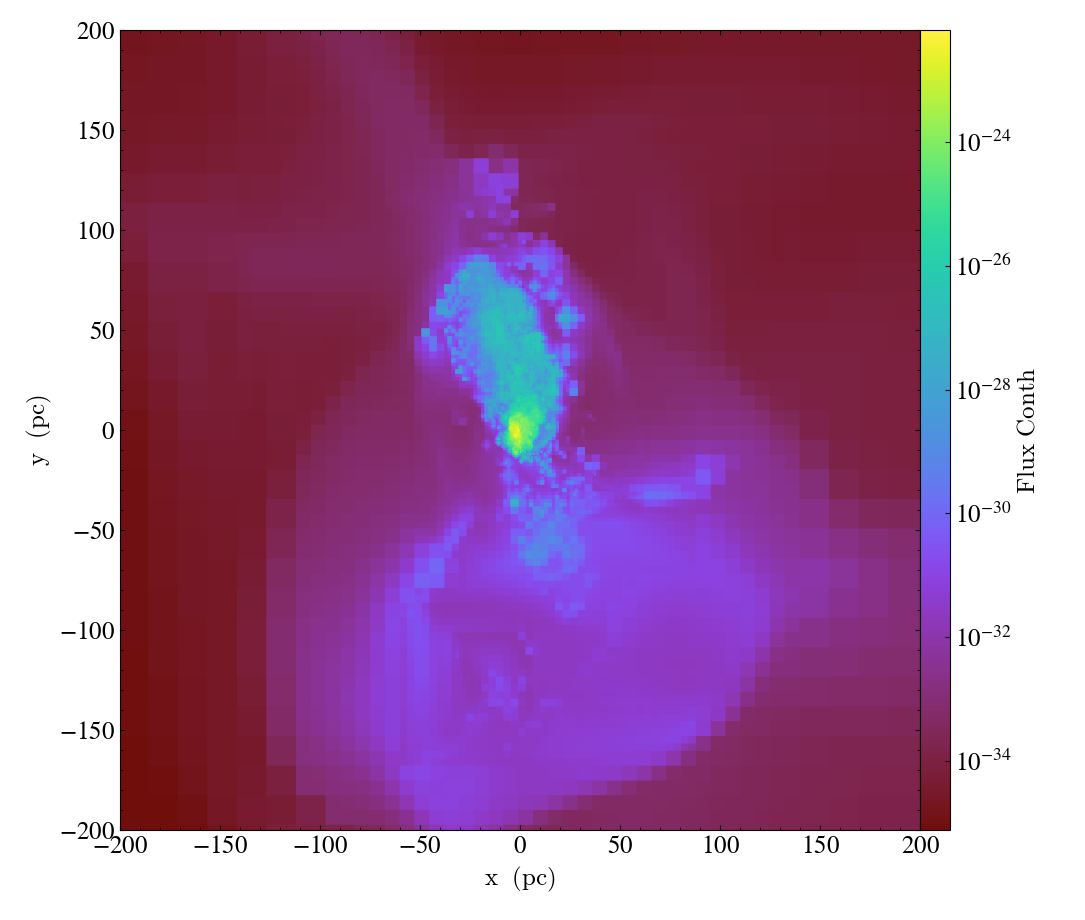

In [159]:
# contH plot
yt.ProjectionPlot(
    ds,
    "z",
    ("gas", "flux_contH"),
    width = (plt_wdth, "pc"),
    weight_field = ("gas", "density"),
    center = ctr_at_code
)

yt : [INFO     ] 2025-04-03 23:39:29,070 Projection completed
yt : [INFO     ] 2025-04-03 23:39:29,073 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 23:39:29,073 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 23:39:29,075 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 23:39:29,076 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 23:39:29,076 Making a fixed resolution buffer of (('gas', 'flux_cont2p')) 800 by 800



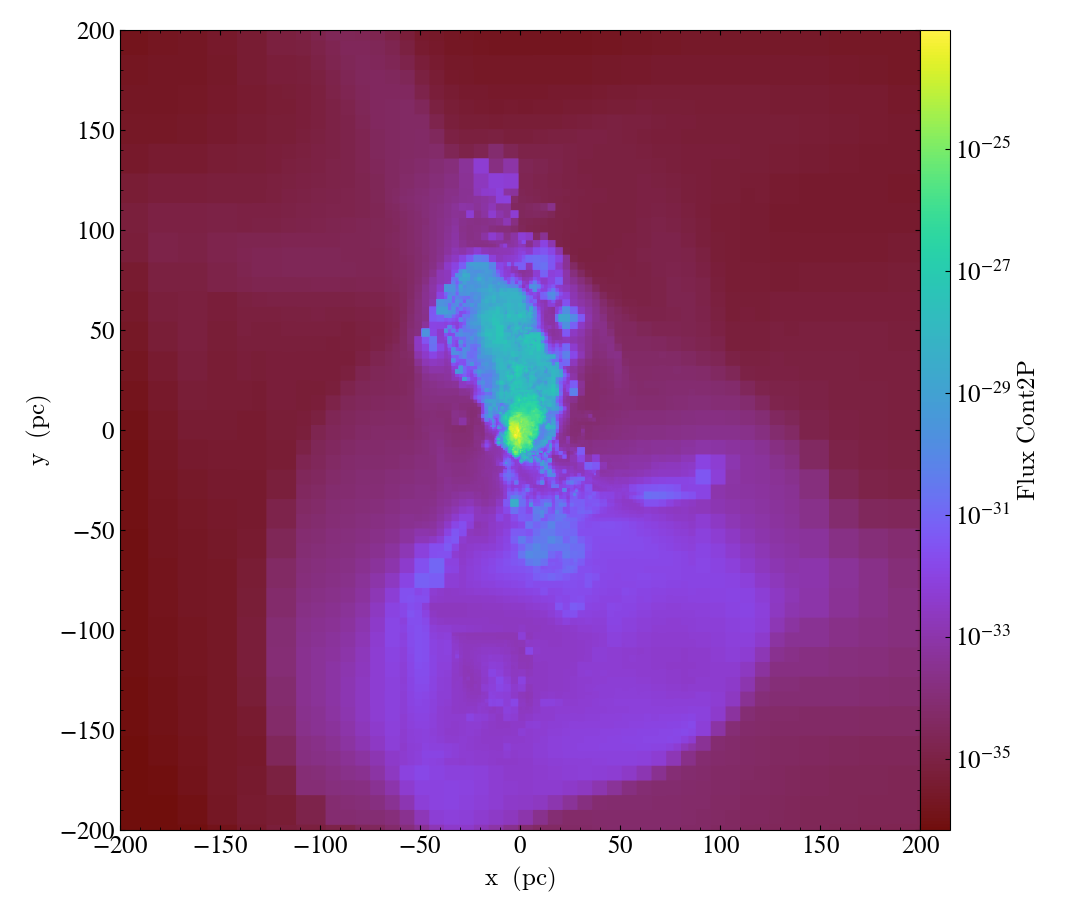

In [161]:
# cont2p plot
yt.ProjectionPlot(
    ds,
    "z",
    ("gas", "flux_cont2p"),
    width = (plt_wdth, "pc"),
    weight_field = ("gas", "density"),
    center = ctr_at_code
)

yt : [INFO     ] 2025-04-03 23:39:39,022 Projection completed
yt : [INFO     ] 2025-04-03 23:39:39,025 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 23:39:39,025 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 23:39:39,028 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 23:39:39,028 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 23:39:39,029 Making a fixed resolution buffer of (('gas', 'flux_contff')) 800 by 800



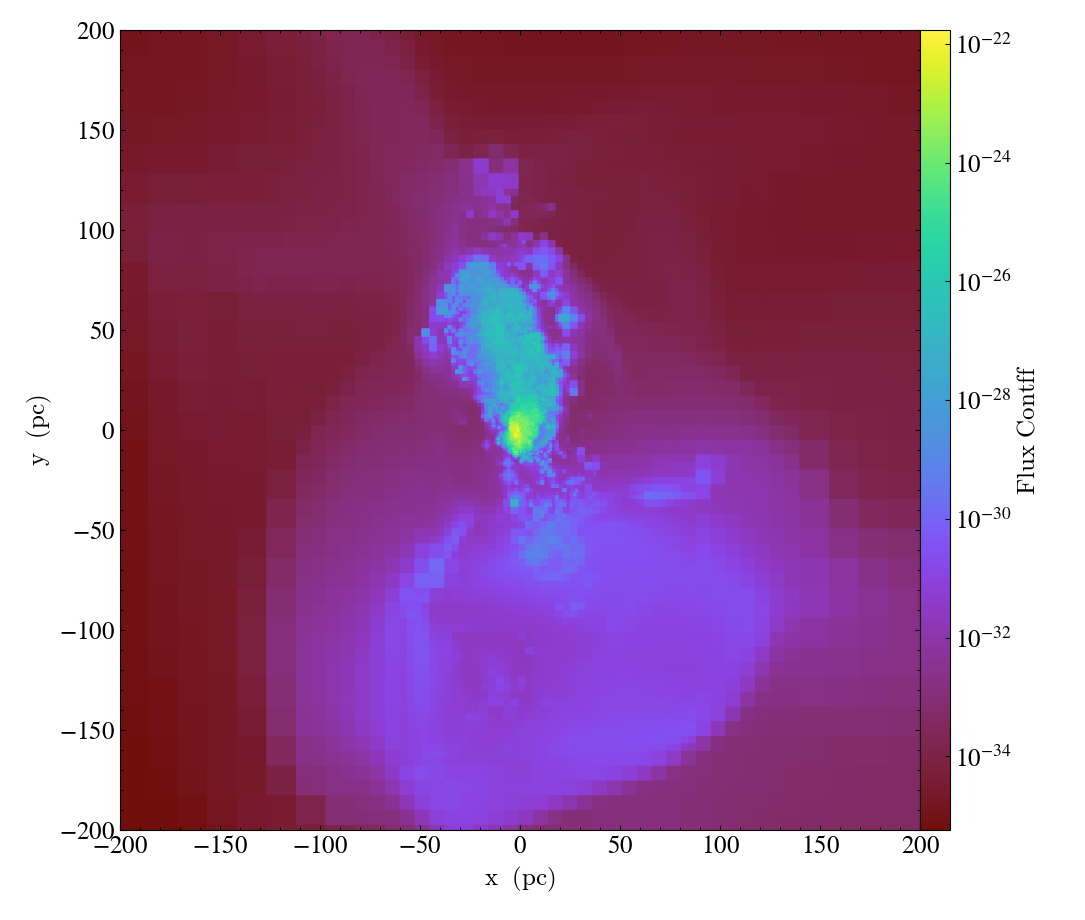

In [163]:
# contff plot
yt.ProjectionPlot(
    ds,
    "z",
    ("gas", "flux_contff"),
    width = (plt_wdth, "pc"),
    weight_field = ("gas", "density"),
    center = ctr_at_code
)

## 2D Histograms of Flux Fields vs Density-Temperature after adding number of proton and electron densities

yt : [INFO     ] 2025-04-03 23:40:44,281 Projection completed
yt : [INFO     ] 2025-04-03 23:40:44,288 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 23:40:44,289 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 23:40:44,295 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 23:40:44,295 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 23:40:44,296 Making a fixed resolution buffer of (('gas', 'flux_contH')) 800 by 800
yt : [INFO     ] 2025-04-03 23:40:49,943 Projection completed
yt : [INFO     ] 2025-04-03 23:40:49,952 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 23:40:49,953 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 23:40:49,956 xlim = 0.491120 0.491223
yt : [INFO     ] 2025-04-03 23:40:49,956 ylim = 0.492725 0.492828
yt : [INFO     ] 2025-04-03 23:40:49,957 Making a fixed resolution buffer of (('gas', 'flux_cont2p')) 800 by 800
yt : [INFO     ] 2025-04-03 23:40:55,415 Projection completed
yt : [INFO     ] 2025-04-03 23:40:55,419 xlim = 0.491120 0.49

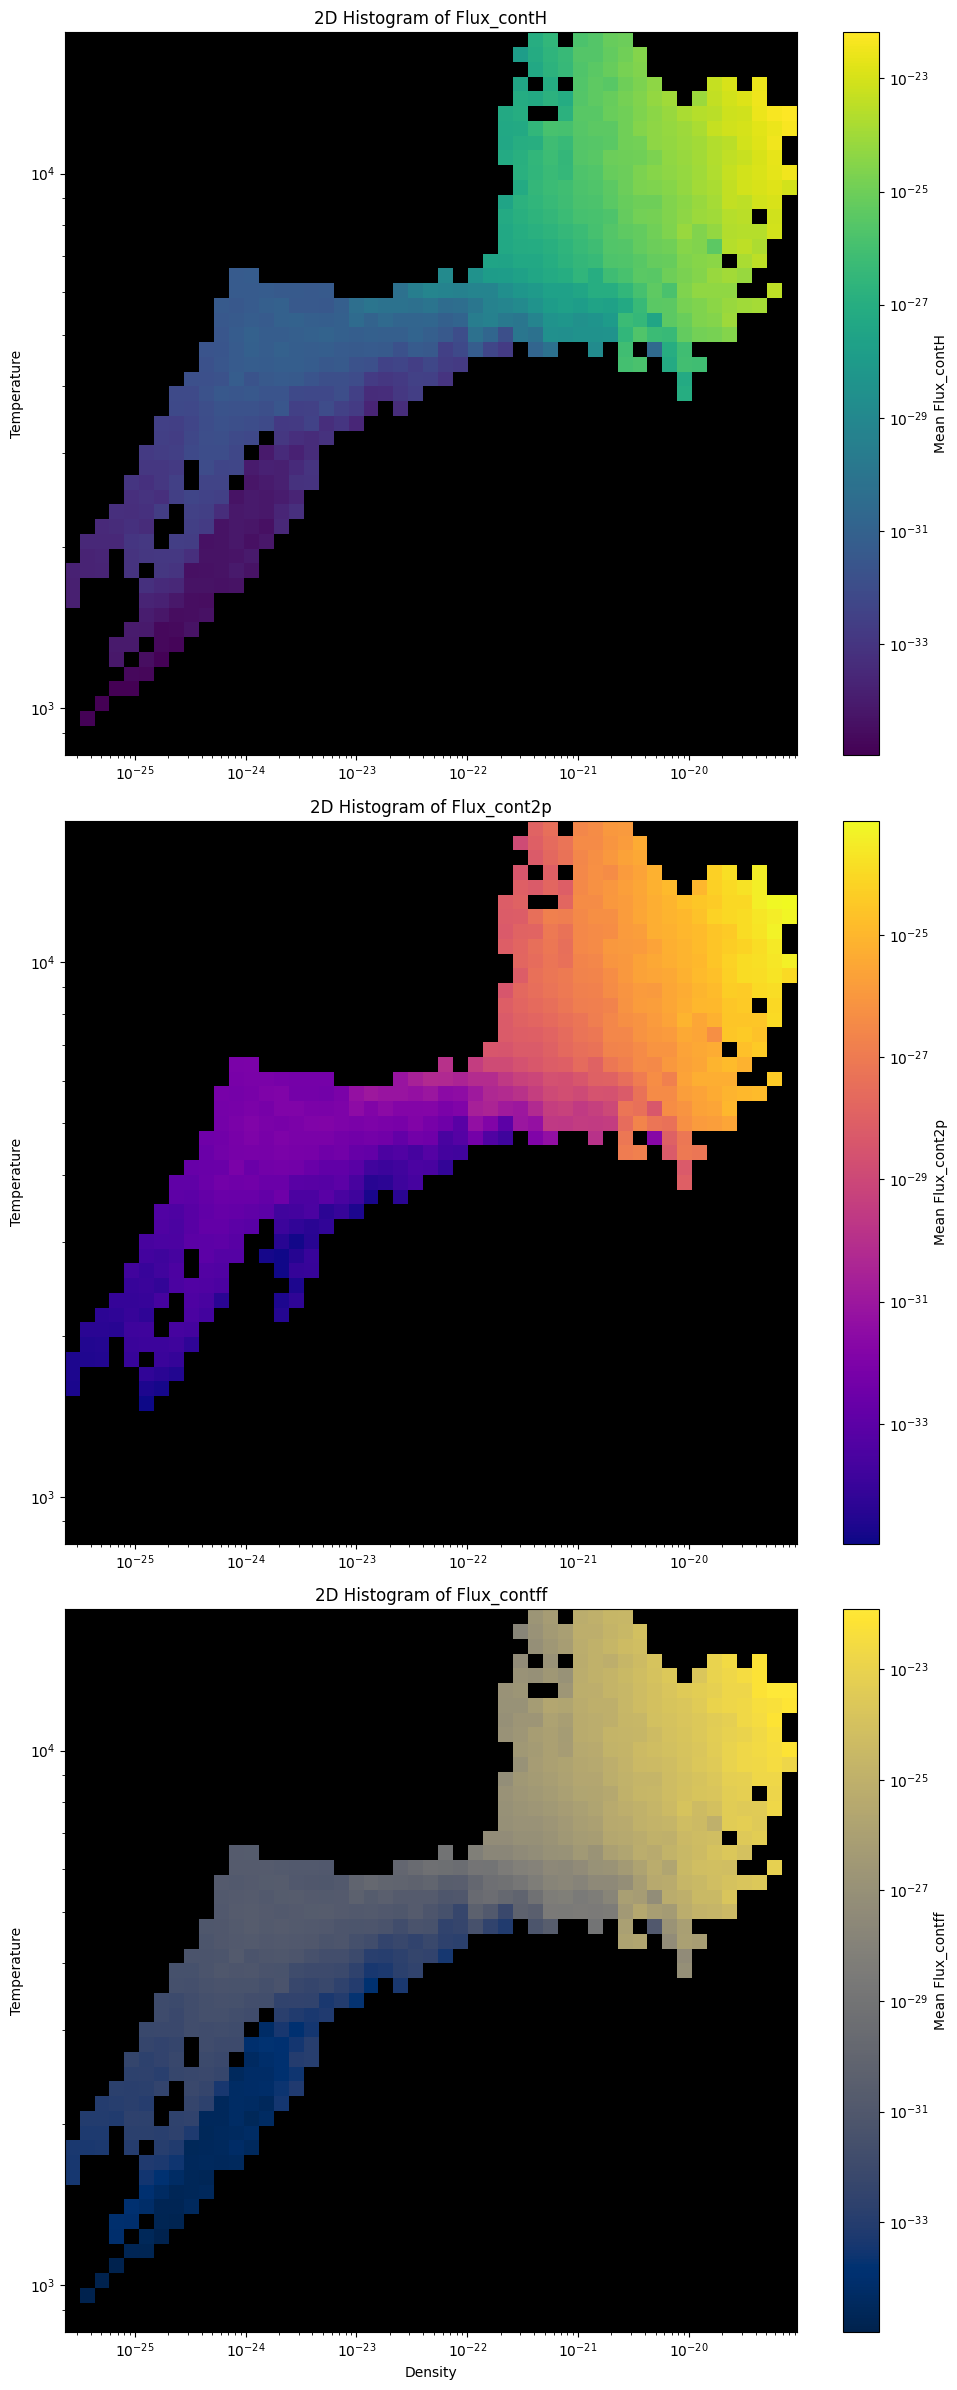

In [166]:
# Create projection plots for each field
p_H = yt.ProjectionPlot(
    ds,
    "z",
    ("gas", "flux_contH"),
    width = (plt_wdth, "pc"),
    weight_field = ("gas", "density"),
    center = ctr_at_code
)

p_2p = yt.ProjectionPlot(
    ds,
    "z",
    ("gas", "flux_cont2p"),
    width = (plt_wdth, "pc"),
    weight_field = ("gas", "density"),
    center = ctr_at_code
)

p_ff = yt.ProjectionPlot(
    ds,
    "z",
    ("gas", "flux_contff"),
    width = (plt_wdth, "pc"),
    weight_field = ("gas", "density"),
    center = ctr_at_code
)

# Get fixed resolution buffers for each field
frb_H = p_H.frb
frb_2p = p_2p.frb
frb_ff = p_ff.frb

# Extract fields from their respective FRBs
flux_contH = frb_H["gas", "flux_contH"].value.flatten()
flux_cont2p = frb_2p["gas", "flux_cont2p"].value.flatten()
flux_contff = frb_ff["gas", "flux_contff"].value.flatten()

# Get density and temperature
density = frb_H["gas", "density"].value.flatten()
temperature = frb_H["gas", "temperature"].value.flatten()

# Handle NaNs
flux_contH = np.where(np.isnan(flux_contH), 1e-35, flux_contH)
flux_cont2p = np.where(np.isnan(flux_cont2p), 1e-35, flux_cont2p)
flux_contff = np.where(np.isnan(flux_contff), 1e-35, flux_contff)

# Create bins
density_bins = np.logspace(np.log10(np.min(density)), np.log10(np.max(density)), num = 50)
temperature_bins = np.logspace(np.log10(np.min(temperature)), np.log10(np.max(temperature)), num = 50)

# Common counts
counts, _, _ = np.histogram2d(density, temperature, bins = [density_bins, temperature_bins])

# Create figure with 3 vertical subplots
plt.figure(figsize = (10, 24))

# Plot 1: flux_contH
plt.subplot(3, 1, 1)
hist_H, xedges, yedges = np.histogram2d(
    density,
    temperature,
    bins = [density_bins, temperature_bins],
    weights = flux_contH
)
hist_norm_H = np.where(counts > 0, hist_H / counts, 0)
masked_H = np.ma.masked_less_equal(hist_norm_H.T, 1e-35)
plot_H = plt.pcolormesh(xedges, yedges, masked_H, norm = LogNorm(), cmap = "viridis")
plot_H.cmap.set_bad('black')
plt.colorbar(label = "Mean Flux_contH")
plt.xscale("log")
plt.yscale("log")
plt.xlim(np.min(density), np.max(density))
plt.ylim(np.min(temperature), np.max(temperature))
plt.ylabel("Temperature")
plt.title("2D Histogram of Flux_contH")

# Plot 2: flux_cont2p
plt.subplot(3, 1, 2)
hist_2p, _, _ = np.histogram2d(
    density,
    temperature,
    bins = [density_bins, temperature_bins],
    weights = flux_cont2p
)
hist_norm_2p = np.where(counts > 0, hist_2p / counts, 0)
masked_2p = np.ma.masked_less_equal(hist_norm_2p.T, 1e-35)
plot_2p = plt.pcolormesh(xedges, yedges, masked_2p, norm = LogNorm(), cmap = "plasma")
plot_2p.cmap.set_bad('black')
plt.colorbar(label = "Mean Flux_cont2p")
plt.xscale("log")
plt.yscale("log")
plt.xlim(np.min(density), np.max(density))
plt.ylim(np.min(temperature), np.max(temperature))
plt.ylabel("Temperature")
plt.title("2D Histogram of Flux_cont2p")

# Plot 3: flux_contff
plt.subplot(3, 1, 3)
hist_ff, _, _ = np.histogram2d(
    density,
    temperature,
    bins = [density_bins, temperature_bins],
    weights = flux_contff
)
hist_norm_ff = np.where(counts > 0, hist_ff / counts, 0)
masked_ff = np.ma.masked_less_equal(hist_norm_ff.T, 1e-35)
plot_ff = plt.pcolormesh(xedges, yedges, masked_ff, norm = LogNorm(), cmap = "cividis")
plot_ff.cmap.set_bad('black')
plt.colorbar(label = "Mean Flux_contff")
plt.xscale("log")
plt.yscale("log")
plt.xlim(np.min(density), np.max(density))
plt.ylim(np.min(temperature), np.max(temperature))
plt.xlabel("Density")
plt.ylabel("Temperature")
plt.title("2D Histogram of Flux_contff")

plt.tight_layout()
plt.show()